# Extract boxes with PyTorch

In [1]:
# !pip install -U toposort
# !pip install pydensecrf
# !pip install pyro-ppl

In [2]:
%load_ext autoreload
%autoreload 2

import multiprocessing

if __name__ == '__main__':
    multiprocessing.set_start_method('spawn', force=True)

import os, glob, json, tqdm, pandas, pickle, rtree, gc, toposort, joblib, tabulate, lxml.etree, bisect
import matplotlib.pyplot as plt
%pylab inline

import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import create_pairwise_bilateral

from imgaug import augmenters as iaa
from imgaug import imgaug as ia
from PIL import Image

from IPython.display import display

from intracell_utils.data_source import *

from prepare_images_utils import *
from latex_dataset import *

Populating the interactive namespace from numpy and matplotlib


## Prepare data source

### Table detection

In [3]:
DET_SRC_DIR = './data/arxiv/inout_pairs/'
all_det_image_ids = [fname[:-9]
                     for fname in glob.glob(os.path.join(DET_SRC_DIR, '*_out.json'))]
random.shuffle(all_det_image_ids)

In [4]:
# all_det_image_ids, strange_det_images = leave_only_valid_samples(all_det_image_ids, prepare_det_batch, fake_imgaug_pipeline)
all_det_image_ids, strange_det_images = all_det_image_ids, []
print('all_det_image_ids', len(all_det_image_ids), 'strange_det_images', len(strange_det_images))
TOTAL_DET_SAMPLES = len(all_det_image_ids)
TRAIN_DET_SAMPLES = int(TOTAL_DET_SAMPLES * 0.8)
VAL_DET_SAMPLES = TOTAL_DET_SAMPLES - TRAIN_DET_SAMPLES
train_det_image_ids = all_det_image_ids[:TRAIN_DET_SAMPLES]
val_det_image_ids = all_det_image_ids[TRAIN_DET_SAMPLES:]
print('train', len(train_det_image_ids), 'val', len(val_det_image_ids))

all_det_image_ids 18208 strange_det_images 0
train 14566 val 3642


### Internal table structure segmentation

In [5]:
# INT_SRC_DIR = './data/generated/full/src/'
# all_int_image_ids = [fname[:-9]
#                      for fname in glob.glob(os.path.join(INT_SRC_DIR, '*_out.json'))]
# random.shuffle(all_int_image_ids)
# len(all_int_image_ids)

In [6]:
# all_int_image_ids, strange_int_images = leave_only_valid_samples(all_int_image_ids, prepare_int_batch, imgaug_pipeline)
# print(len(all_int_image_ids), len(strange_int_images))
# TOTAL_INT_SAMPLES = len(all_int_image_ids)
# TRAIN_INT_SAMPLES = int(TOTAL_INT_SAMPLES * 0.8)
# VAL_INT_SAMPLES = TOTAL_INT_SAMPLES - TRAIN_INT_SAMPLES
# train_int_image_ids = all_int_image_ids[:TRAIN_INT_SAMPLES]
# val_int_image_ids = all_int_image_ids[TRAIN_INT_SAMPLES:]
# print('train', len(train_int_image_ids), 'val', len(val_int_image_ids))

### Generators playground

In [7]:
# def get_demo(image_id):
#     dirname = os.path.dirname(os.path.dirname(image_id))
#     filename = os.path.basename(image_id)
#     return load_image_opaque(os.path.join(dirname, 'demo', filename + '_demo.png'))
# 
# get_demo(all_int_image_ids[0])

In [8]:
# qq = prepare_int_batch(all_int_image_ids[0:10], imgaug_pipeline)
# qq = prepare_det_batch(all_det_image_ids[:10], imgaug_pipeline)

In [9]:
# arr_to_img(qq[1][5][0])

In [10]:
# arr_to_img(mask_to_img(qq[2][5]))

### Compare data generators

In [11]:
# train_gen_mt = DataLoader(SegmDataset(train_image_ids, imgaug_pipeline),
#                           batch_size=8,
#                           shuffle=True,
#                           num_workers=4)
# train_gen_mt_iter = iter(train_gen_mt)
# _ = next(train_gen_mt_iter)

In [12]:
# %%prun
# for _ in range(10):
#     next(train_gen_mt_iter)

In [13]:
# train_gen_st = data_gen(train_image_ids, imgaug_pipeline, batch_size=8)
# train_gen_st_iter = iter(train_gen_st)
# _ = next(train_gen_st_iter)

In [14]:
# %%prun
# for _ in range(10):
#     next(train_gen_st_iter)

## Define losses and metrics

### Discrete

In [15]:
def unsharp_mask(image, kernel=(9, 9), sigma=10, power=0.7):
    blurred = cv2.GaussianBlur(image, kernel, sigma)
    return cv2.addWeighted(image, 1.0, blurred, -power, 0, blurred)


# def get_all_boxes(mask, min_area=100, min_size=(5, 5), threshold=0.5):
def get_all_boxes(mask, min_area=1, min_size=(1, 1)):
    result = []
#     binarized_mask = cv2.adaptiveThreshold((mask*255).astype('uint8'),
#                                            255,
#                                            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#                                            cv2.THRESH_BINARY,
#                                            11,
#                                            50)
    mask_img = (mask*255).astype('uint8')
#     display('src mask')
#     display(arr_to_img((mask_img / 255).astype('float32')))
    
#     mask_img = unsharp_mask(mask_img)
    
#     display('unsharp mask')
#     display(arr_to_img((mask_img / 255).astype('float32')))
    
    _, binarized_mask = cv2.threshold(mask_img,
                                      0,
                                      255,
                                      cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    binarized_mask[:, 0] = binarized_mask[:, -1] = binarized_mask[0, :] = binarized_mask[-1, :] = 0
#     display(arr_to_img((binarized_mask / 255).astype('float32')))
    contours = cv2.findContours(binarized_mask,
                                cv2.RETR_LIST,
                                cv2.CHAIN_APPROX_SIMPLE)[1]
    for cnt in contours:
        if cv2.contourArea(cnt) < min_area:
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        if h < min_size[0] or w < min_size[1]:
            continue
        result.append((y, x, y+h, x+w))
    result.sort()
    return result


def filter_boxes_by_overlap(boxes, min_overlap=0.9):
    boxes = list(boxes)
    boxes.sort(key=box_area)
    while True:
        boxes_to_remove = set()
        for i, cur in enumerate(boxes):
            for j, bigger in enumerate(boxes[i+1:]):
                overlap = box_inter_area(cur, bigger) / box_area(cur)
                if overlap >= min_overlap:
                    boxes_to_remove.add(i)
                    break
        if len(boxes_to_remove) == 0:
            break
        boxes = [b for i, b in enumerate(boxes) if i not in boxes_to_remove]
    return boxes
        


def get_boxes_by_channel(pred, **kwargs):
    pred_boxes = collections.defaultdict(list)
    for channel in range(pred.shape[0]):
        pred_boxes[channel] = filter_boxes_by_overlap(get_all_boxes(pred[channel], **kwargs))
    return pred_boxes


def get_boxes_by_channel_and_filter(pred, from_channel=2, to_channel=TOTAL_INT_CLASSES, body_channel=1):
    pred_boxes = collections.defaultdict(list)
    pred_boxes[body_channel] = get_all_boxes(pred[body_channel])
    if len(pred_boxes[body_channel]) > 0:
        pred_body = get_biggest_box(pred_boxes[body_channel])
        for ch in range(from_channel, to_channel):
            cand_boxes = get_all_boxes(pred[ch])
            cand_idx = filter_by_intersection(pred_body, cand_boxes)
            pred_boxes[ch] = [cand_boxes[i] for i in cand_idx]
    return pred_boxes



def calc_dice(box, other):
    return 2 * box_inter_area(box, other) / (box_area(box) + box_area(other))


def calc_inter_over_other_area(box, other):
    return box_inter_area(box, other) / box_area(other)


def find_closest_box(box, others, min_overlap=0.8, calc_overlap=calc_dice):
    best_overlap = 0
    best_idx = None
    for i, other in enumerate(others):
        overlap = calc_overlap(box, other)
        if overlap > best_overlap:
            best_idx = i
            best_overlap = overlap
    return best_idx


def match_boxes_by_biggest_overlap_1to1(gold_regions, pred_regions):
    overlaps = [(gi, pi, intersection, len(pelems - gelems))
                for gi, gelems in enumerate(gold_regions)
                for pi, pelems in enumerate(pred_regions)
                for intersection in [len(gelems & pelems)]
                if intersection > 0]
    overlaps = numpy.array(overlaps)
    
    g_idx = collections.defaultdict(set)
    p_idx = collections.defaultdict(set)
    for i, (gi, pi, _, _) in enumerate(overlaps):
        g_idx[gi].add(i)
        p_idx[pi].add(i)

    matched_golds = set()
    matched_preds = set()
    matched_pairs = set()

    for gi, pi, intersection, foreign in overlaps:
        if gi in matched_golds or pi in matched_preds:
            continue
        matched_golds.add(gi)
        matched_preds.add(pi)
        matched_pairs.add((gi, pi))
    return [(gold_regions[gi], pred_regions[pi]) for gi, pi in matched_pairs]


def classify_boxes(pred_boxes, gold_boxes, strictness=0.8, calc_overlap=calc_dice):
    true_positive = []
    false_positive = []

    found_gold = set()
    pred_i_to_gold_i = {}
    for i, box in enumerate(pred_boxes):
        closest_gold_i = find_closest_box(box, gold_boxes, min_overlap=strictness, calc_overlap=calc_overlap)
        if not closest_gold_i is None:
            pred_i_to_gold_i[i] = closest_gold_i
            true_positive.append(i)
            found_gold.add(closest_gold_i)
        else:
            false_positive.append(i)

    false_negative = set(range(len(gold_boxes))) - found_gold
    return (true_positive, false_positive, false_negative, pred_i_to_gold_i)


def calc_precision(tp, fp, fn):
    denom = float(tp + fp)
    return (tp / denom) if denom > 1e-4 else 0.0


def calc_recall(tp, fp, fn):
    denom = float(tp + fn)
    return (tp / denom) if denom > 1e-4 else 0.0


def calc_f1(tp, fp, fn):
    p = calc_precision(tp, fp, fn)
    r = calc_recall(tp, fp, fn)
    denom = p + r
    return (2 * p * r / denom) if denom > 1e-4 else 0.0


def calc_metric_over_boxes(pred_boxes, gold_boxes, metric, strictness=0.8, calc_overlap=calc_dice):
    result = []
    for ch in range(len(gold_boxes)):
        tp, fp, fn, _ = classify_boxes(pred_boxes.get(ch, []),
                                       gold_boxes.get(ch, []),
                                       strictness=strictness,
                                       calc_overlap=calc_overlap)
        tp, fp, fn = len(tp), len(fp), len(fn)
        result.append(metric(tp, fp, fn))
    return result


def box_match_single_image(pred, gold_boxes, metric, strictness=0.8, calc_overlap=calc_dice):
    pred_boxes = get_boxes_by_channel_and_filter(pred)
    return calc_metric_over_boxes(pred_boxes,
                                  gold_boxes,
                                  metric,
                                  strictness=strictness,
                                  calc_overlap=calc_overlap)


def box_match_batch(pred, gold_boxes, metric, strictness=0.8, calc_overlap=calc_dice):
    if not isinstance(pred, numpy.ndarray):
        pred = pred.data.cpu().numpy()
    image_metrics = [box_match_single_image(pred[i],
                                            gold_boxes[i],
                                            metric,
                                            strictness=strictness,
                                            calc_overlap=calc_overlap)
                     for i in range(pred.shape[0])]
    return numpy.array(image_metrics).mean(0)


def box_match_precision(pred, target, gold_boxes, strictness=0.95):
    return box_match_batch(pred, gold_boxes, calc_precision,
                           strictness=strictness,
                           calc_overlap=calc_dice)


def box_match_recall(pred, target, gold_boxes, strictness=0.95):
    return box_match_batch(pred, gold_boxes, calc_recall,
                           strictness=strictness,
                           calc_overlap=calc_inter_over_other_area)


def box_match_f1(pred, target, gold_boxes, strictness=0.95):
    return box_match_batch(pred, gold_boxes, calc_f1,
                           strictness=strictness,
                           calc_overlap=calc_inter_over_other_area)


def fill_boxes_on_mask_single_image(mask, max_iterations=3):
    for _ in range(max_iterations):
        boxes_dict = get_boxes_by_channel(mask)
        boxes_lst = [boxes_dict[i] for i in range(mask.shape[0])]
        mask = make_mask_for_nn_base(mask.shape[1:], mask.shape[0], boxes_lst)
    return mask


def fill_boxes_on_mask_batch(mask_batch, max_iterations=3):
    result = numpy.zeros_like(mask_batch)
    for i in range(mask_batch.shape[0]):
        result[i] = fill_boxes_on_mask_single_image(mask_batch[i], max_iterations=max_iterations)
    return result


# box_match_precision(numpy.tile(numpy.array([[[[1, 1, 1, 1], [1, 1, 1, 1]]]]), (1, 5, 1, 1)),
#                     None,
#                     [{2 : [[0, 0, 2, 4]]}])

### Table level

In [90]:
def flatten_cell_dependencies(grid):
    full_deps = { i : set(itertools.chain.from_iterable(neighbors.values()))
                 for i, neighbors in enumerate(grid) }
    for cell_i, neigbors in full_deps.items():
        neighs_to_remove = set()
        for neigh in neigbors:
            if cell_i in full_deps[neigh]:
                neighs_to_remove.add(neigh)
        neigbors -= neighs_to_remove
    return full_deps


def filter_boxes_by_real_pixels(boxes, image, max_mean=0.98, min_mean=0.02):
    result = []
    for box in boxes:
        y1, x1, y2, x2 = box
        mean = image[y1:y2+1, x1:x2+1].mean()
        if mean >= min_mean and mean <= max_mean:
            result.append(box)
    return result


def merge_close_cells(cells, dx=0.5, dy=0.5):
    cells = list(cells)
    idx = rtree.index.Index(interleaved=True)
    idx2cell = {}
    for i, c in enumerate(cells):
        idx.insert(i, c)
        idx2cell[i] = c
    next_id = len(idx2cell)

    merged_anything = True
    while merged_anything:
        merged_anything = False
        for i, (y1, x1, y2, x2) in idx2cell.items():
            neighbors = set()
            neighbors.update(idx.intersection((y1-dy, x1, y2+dy, x2)))
            neighbors.update(idx.intersection((y1, x1-dx, y2, x2+dx)))
            neighbors = {j for j in neighbors if j in idx2cell}
            if len(neighbors) > 1:
                idx2cell[next_id] = just_box_union([idx2cell[j] for j in neighbors])
                next_id += 1
                for j in neighbors:
                    del idx2cell[j]
                merged_anything = True
                break
    return list(idx2cell.values())


NO_GRID = (None, (), (), (), {})
def table_grid_from_intracell_mask(mask, input_image=None, box_content_getter=None, content_filter=None):
    body_candidates = get_all_boxes(mask[0])
#     if len(body_candidates) == 0:
#         return NO_GRID
    body = (0, 0, 0, 0) #get_biggest_box(body_candidates)
#     cells = filter_boxes_by_overlap(get_all_boxes(mask[1]))
    cells = get_all_boxes(mask[1])
    if len(cells) == 0:
        return NO_GRID
    if not input_image is None:
        cells = filter_boxes_by_real_pixels(cells, input_image)
    if box_content_getter:
        cell_contents = [box_content_getter(cell) for cell in cells]
        cells_with_contents = [(cell, content)
                               for cell, content in zip(cells, cell_contents)
                               if content]
        if content_filter is None:
            content_filter = lambda x: True
        cells = [cell for cell, content in cells_with_contents if content_filter(content)]
    print(cells)
    cells = merge_close_cells(cells)
    grid = make_grid(cells)
    full_deps = flatten_cell_dependencies(grid)
    cell_idx = list(full_deps.keys()) # toposort.toposort_flatten(full_deps)
    intracell_relations = {}
    for cur_cell_i in cell_idx:
        cur_cell = cells[cur_cell_i]
        for direction, dir_neighbors in grid[cur_cell_i].items():
            for neigh_cell_i in dir_neighbors:
                intracell_relations[(cur_cell_i, neigh_cell_i)] = direction
    return (body, cells, grid, cell_idx, intracell_relations)


def reconstruct_table_from_grid(body, cells, grid, cell_idx, intracell_space_classes):
    cell2row = collections.defaultdict(set)
    cell2col = collections.defaultdict(set)

    for cur_cell_i in cell_idx:
        cur_cell = cells[cur_cell_i]
        lower_neighbors = grid[cur_cell_i]['lower']
        if len(lower_neighbors) == 0:
            cell2col[cur_cell_i] = { len(cell2col) }
        right_neighbors = grid[cur_cell_i]['right']
        if len(right_neighbors) == 0:
            cell2row[cur_cell_i] = { len(cell2row) }

        for neigh_cell_i in lower_neighbors | right_neighbors:
            intracell_cls_proba = intracell_space_classes[(cur_cell_i, neigh_cell_i)]
            if intracell_cls_proba[0] > 0.5:
                cell2row[cur_cell_i].update(cell2row[neigh_cell_i])
            elif intracell_cls_proba[1] > 0.5:
                cell2col[cur_cell_i].update(cell2col[neigh_cell_i])
            else:
                pass # they are not linked

    rows = collections.defaultdict(set)
    for cell_i, cell_rows_idx in cell2row.items():
        for row_i in cell_rows_idx:
            rows[row_i].add(cell_i)

    cols = collections.defaultdict(set)
    for cell_i, cell_cols_idx in cell2col.items():
        for col_i in cell_cols_idx:
            cols[col_i].add(cell_i)

    row_boxes = [just_box_union([cells[i] for i in row_idx])
                 for row_idx in rows.values()]
    row_boxes.sort(key=lambda b: (b[0], b[1]))

    col_boxes = [just_box_union([cells[i] for i in col_idx])
                 for col_idx in cols.values()]
    col_boxes.sort(key=lambda b: (b[1], b[0]))
    return (body,
            cells,
            row_boxes,
            col_boxes)


def reconstruct_table_from_intracell_mask(mask, interbox_classifier):
    body, cells, grid, cell_idx, intracell_relations = table_grid_from_intracell_mask(mask)
    intracell_space_classes = { k : interbox_classifier([mask], [pair])
                               for pair in intracell_relations }
    return reconstruct_table_from_grid(body, cells, grid, cell_idx, intracell_space_classes)


def boxes_by_channel_from_reconstructed_table(mask):
    table_info = reconstruct_table_from_intracell_mask(mask)
    if table_info is None:
        return {}
    body, cells, rows, cols = table_info
    result = { 1 : [body] }
    result[2] = cells
    result[3] = rows
    result[4] = cols
    return result


def table_level_metric_single_image(pred, gold_boxes, metric, strictness=0.5):
    pred_boxes = boxes_by_channel_from_reconstructed_table(pred)
    return calc_metric_over_boxes(pred_boxes, gold_boxes, calc_precision, strictness=strictness)


def table_level_metric_by_batch(pred, gold_boxes, metric, strictness=0.5):
    if not isinstance(pred, numpy.ndarray):
        pred = pred.data.cpu().numpy()
    image_metrics = [table_level_metric_single_image(pred[i],
                                                     gold_boxes[i],
                                                     metric,
                                                     strictness=strictness)
                     for i in range(pred.shape[0])]
    return numpy.array(image_metrics).mean(0)

def table_level_precision(pred, target, gold_boxes, strictness=0.5):
    return table_level_metric_by_batch(pred, gold_boxes, calc_precision, strictness=strictness)


def table_level_recall(pred, target, gold_boxes, strictness=0.5):
    return table_level_metric_by_batch(pred, gold_boxes, calc_recall, strictness=strictness)

### Fuzzy

$Dice(p, t, w) = 1 - \frac{ p \cdot t + 1 }{ p + t + 1 }$

$WDice(p, t, w) = 1 - \frac{ p \cdot t \cdot w^{-1} + 1 }{ p + t + p \cdot (1 - t) \cdot w + 1 }$

In [18]:
DICE_SMOOTH = 1.0
def dice_coef(pred, target, gold_boxes):
    intersection = pred * target
    union = pred + target
    return ((2. * intersection.sum(3).sum(2).sum(0) + DICE_SMOOTH) /
            (union.sum(3).sum(2).sum(0) + DICE_SMOOTH))


def px_precision(pred, target, gold_boxes, threshold=0.5):
    pred = (pred >= threshold).float()
    target = (target >= threshold).float()
    tp = (pred * target).float().sum(3).sum(2).sum(0)
    fp = ((target - pred) < 0).float().sum(3).sum(2).sum(0)
    denum = tp + fp
    return tp / (denum + (denum == 0).float())


def px_recall(pred, target, gold_boxes, threshold=0.5):
    pred = (pred >= threshold).float()
    target = (target >= threshold).float()
    tp = (pred * target).float().sum(3).sum(2).sum(0)
    fn = ((pred - target) < 0).float().sum(3).sum(2).sum(0)
    denum = tp + fn
    return tp / (denum + (denum == 0).float())


def dice_on_boxes(pred, target, gold_boxes):
    return dice_coef(fill_boxes_on_mask_batch(pred.data.cpu().numpy()), target.data.cpu().numpy(), gold_boxes)


def make_single_channel(f, channel):
    def _impl(pred, target):
        return f(pred[:, channel:channel+1], target[:, channel:channel+1])
    return _impl


def make_cpu(f):
    def _impl(pred, target):
        return f(pred.cpu(), target.cpu())
    return _impl


def _make_key_from_metric_title(txt):
    levels = txt.split('\n', 1)
    if len(levels) < 2:
        levels.append('value')
    return tuple(levels)


def compactify_metrics_table(metrics_df):
    data = { _make_key_from_metric_title(c) : '{:.2f}±{:.2f}'.format(metrics_df[c]['mean'], metrics_df[c]['std'])
            for c in metrics_df.columns }
    idx = pandas.MultiIndex.from_tuples(data.keys())
    return pandas.Series(data, index=idx).unstack(level=0)


def format_metrics_table_md(df):
    df = compactify_metrics_table(df.describe())
    print(tabulate.tabulate(df, df.columns, tablefmt='pipe'))


TRAIN_DET_METRICS = {'d' : (dice_coef, DET_MASK_CHANNELS),
                     }
VAL_DET_METRICS = {'d' : (dice_coef, DET_MASK_CHANNELS),
                   'bd' : (dice_on_boxes, DET_MASK_CHANNELS),
                   'px_p' : (px_precision, DET_MASK_CHANNELS),
                   'px_r' : (px_recall, DET_MASK_CHANNELS)
                   }


TRAIN_INT_METRICS = {'d' : (dice_coef, INT_MASK_CHANNELS),
#                      'bp' : (box_match_precision, INT_MASK_CHANNELS),
#                      'br' : (box_match_recall, INT_MASK_CHANNELS),
#                      'bf' : (box_match_f1, INT_MASK_CHANNELS),
#                      'px_p' : (px_precision, INT_MASK_CHANNELS),
#                      'px_r' : (px_recall, INT_MASK_CHANNELS)
                     }
VAL_INT_METRICS = {'d' : (dice_coef, INT_MASK_CHANNELS),
#                'bp' : (box_match_precision, INT_MASK_CHANNELS),
#                'br' : (box_match_recall, INT_MASK_CHANNELS)
#                'tp' : (table_level_precision, INT_MASK_CHANNELS),
#                'tr' : (table_level_recall, INT_MASK_CHANNELS),
                   'px_p' : (px_precision, INT_MASK_CHANNELS),
                   'px_r' : (px_recall, INT_MASK_CHANNELS)
                   }
TEST_INT_METRICS = {'d' : (dice_coef, INT_MASK_CHANNELS),
                    'bp' : (box_match_precision, INT_MASK_CHANNELS),
                    'br' : (box_match_recall, INT_MASK_CHANNELS),
                    'bf' : (box_match_f1, INT_MASK_CHANNELS),
                    'px_p' : (px_precision, INT_MASK_CHANNELS),
                    'px_r' : (px_recall, INT_MASK_CHANNELS)
                    }

### IID Classification

In [19]:
def prepare_metric_data_by_columns(pred, target):
    pred = (pred.data.cpu().numpy() > 0.5).astype('int')
    target = (target.data.cpu().numpy() > 0.5).astype('int')
    tp = numpy.array([(pred[:, col] == target[:, col]).sum()
                      for col in range(pred.shape[1])]).astype('float32')
    fp = numpy.array([((pred[:, col] - target[:, col]) > 0).sum()
                      for col in range(pred.shape[1])]).astype('float32')
    fn = numpy.array([((target[:, col] - pred[:, col]) > 0).sum()
                      for col in range(pred.shape[1])]).astype('float32')
    return tp, fp, fn


def precision_by_col(pred, target):
    tp, fp, fn = prepare_metric_data_by_columns(pred, target)
    return numpy.nan_to_num(tp / (tp + fp))


def recall_by_col(pred, target):
    tp, fp, fn = prepare_metric_data_by_columns(pred, target)
    return numpy.nan_to_num(tp / (tp + fn))


def f1_by_col(pred, target):
    tp, fp, fn = prepare_metric_data_by_columns(pred, target)
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    return numpy.nan_to_num(2 * p * r / (p + r))


CELL_CLASSES = ('same_row', 'same_col')
CELL_TRAIN_METRICS = {'f1' : (f1_by_col, CELL_CLASSES),
                      'p' : (precision_by_col, CELL_CLASSES),
                      'r' : (recall_by_col, CELL_CLASSES) }
CELL_VAL_METRICS = {'f1' : (f1_by_col, CELL_CLASSES),
                    'p' : (precision_by_col, CELL_CLASSES),
                    'r' : (recall_by_col, CELL_CLASSES) }

### Losses

In [20]:
def dice_score(pred, target):
    intersection = pred * target
    union = pred + target
    return ((2. * intersection.sum() + DICE_SMOOTH) /
                (union.sum() + DICE_SMOOTH))

def dice_loss(pred, target, weights):
    return 1 - dice_score(pred, target)


def weighted_dice_loss(pred, target, weights):
    # the idea is to lower actual intersection in important areas
    inv_weights = 1 / weights
    intersection = pred * inv_weights * target
    
    # the idea is to increase actual predicted values
    # where they have to be zero
    inv_target = 1 - target
    inv_intersection = pred * inv_target * weights
    union = pred + target + inv_intersection

    return 1 - ((2. * intersection.sum() + DICE_SMOOTH) /
                (union.sum() + DICE_SMOOTH))


def dice_bce_loss(pred, target, weights):
#     return dice_loss(pred, target, weights) + F.binary_cross_entropy(pred, target, weights)
    return F.binary_cross_entropy(pred, target, weights) - torch.log(dice_score(pred, target))

## Define a network

### Basic

In [21]:
def mcuda(x, cuda):
    return x.cuda() if cuda else x


def npten(arr, cuda):
    return mcuda(torch.from_numpy(arr), cuda)


def npvar(arr, cuda):
    if not torch.is_tensor(arr):
        arr = torch.from_numpy(arr)
    return mcuda(Variable(arr), cuda)


def is_module_on_cuda(m):
    return next(m.parameters()).is_cuda


class LocalAttention(nn.Module):
    def __init__(self, in_channels):
        super(LocalAttention, self).__init__()
        self.att = nn.Conv2d(in_channels, 1, (1, 1))

    def forward(self, x):
        unnorm = self.att(x)
        norm = F.softmax(unnorm.view(unnorm.size()[0], -1)).view(*unnorm.size())
        return x * norm


def masked_average(x, masks):
    return (x * masks).mean(3).mean(2)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilations=[1], bn=True, out_act=F.relu,
                 conv_layer=nn.Conv2d, norm_layer=nn.BatchNorm2d):
        super(ConvBlock, self).__init__()
        self.bn = norm_layer(int(in_channels))
        assert out_channels % len(dilations) == 0
        channels_per_dilation = int(out_channels // len(dilations))
        self.convs = nn.ModuleList([conv_layer(in_channels,
                                               channels_per_dilation,
                                               kernel_size,
                                               padding=dil,
                                               dilation=dil)
                                    for dil in dilations])
        self.out_act = out_act
        self.out_channels = out_channels

    def forward(self, x):
        x = self.bn(x)
        conv_outs = [conv(x) for conv in self.convs]
        return self.out_act(torch.cat(conv_outs, dim=1))

    @property
    def receptive_field(self):
        dils = numpy.array([c.dilation for c in self.convs])
        kernels = numpy.array([c.kernel_size for c in self.convs])
        kernels_odd = kernels % 2
        return (dils * (kernels - 1) + kernels_odd).max(axis=0)


class ConvBlock1d(ConvBlock):
    def __init__(self, in_channels, out_channels, kernel_size, dilations=[1], bn=True, out_act=F.relu):
        super(ConvBlock1d, self).__init__(in_channels, out_channels, kernel_size,
                                          dilations=dilations,
                                          bn=bn,
                                          out_act=out_act,
                                          conv_layer=nn.Conv1d,
                                          norm_layer=nn.BatchNorm1d)


class UNet(nn.Module):
    def __init__(self, out_channels=TOTAL_INT_CLASSES, first_conv_channels=4, depth=2, out_layers=1, conv_kernel=3,
                 enc_dilations=[1], dec_dilations=[1], out_dilations=[1], convblock=ConvBlock):
        super(UNet, self).__init__()
        self.out_channels = out_channels
        enc_channels = [int(1)] + [int(first_conv_channels * (2**step)) for step in range(depth)]
        self.encoder = nn.ModuleList([convblock(enc_channels[i],
                                                enc_channels[i+1],
                                                kernel_size=conv_kernel,
                                                dilations=enc_dilations)
                                      for i in range(depth)])
        bottleneck_channels = enc_channels[-1] * 2
        self.bottleneck = convblock(enc_channels[-1],
                                    bottleneck_channels,
                                    kernel_size=conv_kernel,
                                    dilations=enc_dilations)
        dec_channels = [bottleneck_channels] + enc_channels[:0:-1]

        self.dec_conv = nn.ModuleList([convblock(dec_channels[i],
                                                 dec_channels[i+1],
                                                 kernel_size=conv_kernel,
                                                 dilations=dec_dilations)
                                      for i in range(depth)])
        self.dec_deconv = nn.ModuleList([nn.ConvTranspose2d(dec_channels[i],
                                                            dec_channels[i+1],
                                                            (2, 2),
                                                            stride=2)
                                         for i in range(depth)])
        self.out_layers = nn.ModuleList([convblock(dec_channels[-1],
                                                   dec_channels[-1],
                                                   kernel_size=conv_kernel,
                                                   dilations=out_dilations)
                                         for _ in range(out_layers)])
        self.out_conv = nn.Conv2d(dec_channels[-1],
                                  out_channels,
                                  (1, 1))

    def forward(self, x):
        enc_conv_outs = []
        enc_pool_outs = [x]
        for enc_conv in self.encoder:
            cur_conv_out = enc_conv(enc_pool_outs[-1])
            enc_conv_outs.append(cur_conv_out)
            cur_pool_out = F.max_pool2d(cur_conv_out, (2, 2))
            enc_pool_outs.append(cur_pool_out)

        internal_outs = []
        internal_outs.extend(enc_conv_outs)

        cur_out = self.bottleneck(enc_pool_outs[-1])
        internal_outs.append(cur_out)

        for dec_step, (dec_conv, dec_deconv) in enumerate(zip(self.dec_conv, self.dec_deconv)):
            up = dec_deconv(cur_out)
            cur_out = torch.cat([up, enc_conv_outs[-dec_step-1]], dim=1)
            cur_out = dec_conv(cur_out)
            internal_outs.append(cur_out)

        for out_layer in self.out_layers:
            cur_out = F.relu(out_layer(cur_out))
            internal_outs.append(cur_out)

        final_out = self.out_conv(cur_out)
        internal_outs.append(final_out)

        return F.sigmoid(final_out), internal_outs


def SeparableUNet(*args, **kwargs):
    kwargs['convblock'] = SeparableConvBlock2d
    return UNet(*args, **kwargs)


class SimpleConvFCN(nn.Module):
    def __init__(self, in_channels, out_channels, conv_layers=1, conv_kernel=(3, 3), dilations=[1, 2, 4], conv_block_class=ConvBlock):
        super(SimpleConvFCN, self).__init__()
        conv_channels = [in_channels] + [len(dilations) * (2 ** (i + 1)) for i in range(conv_layers)]
        print('conv channels', conv_channels)
        self.convs = nn.ModuleList([conv_block_class(conv_channels[i],
                                                     conv_channels[i+1],
                                                     conv_kernel,
                                                     dilations=dilations)
                                    for i in range(conv_layers)])
        self.output = nn.Linear(conv_channels[-1], out_channels)

    def forward(self, x):
        for conv in self.convs:
            x = conv(x)
        x = self.output(x.transpose(1, -1)).transpose(1, -1)
        return F.sigmoid(x)

    @property
    def receptive_field(self):
        conv_fields = [c.receptive_field for c in self.convs]
        result = conv_fields[0]
        for i in range(1, len(conv_fields)):
            result += numpy.clip(conv_fields[i] // 2, 1, None)
        return result


class DenseNetWrapper(nn.Module):
    def __init__(self, *blocks):
        super(DenseNetWrapper, self).__init__()
        self.blocks = nn.ModuleList(list(blocks))

    def forward(self, x):
        last_out = x
        for block in self.blocks:
            last_out = block(x)
            x = torch.cat([x, last_out], 1)
        return last_out


class Linear1dMixture(nn.Module):
    def __init__(self, n_sources, n_channels):
        super(Linear1dMixture, self).__init__()
        self.weights = nn.ModuleList([nn.Linear(n_sources, 1, bias=False)
                                      for _ in range(n_channels)])
        self.n_sources = n_sources

    def forward(self, x):
        """
        Expects tensor of shape (n_sources, B, n_channels, *)
        """
        src_size = tuple(x.size())
        # transpose to (n_channels, B, *, n_sources)
        forward_axis_order = (2, 1) + tuple(range(3, len(src_size))) + (0,)
        x = x.permute(*forward_axis_order)
        weighted_sums = [channel_weights(x[i])
                         for i, channel_weights
                         in enumerate(self.weights)]
        print('weighted_sums', weighted_sums[0].size())
        1 / 0
        return torch.cat(weighted_sums) / n_sources
        


class DenseStack(nn.Module):
    def __init__(self, *blocks):
        super(DenseStack, self).__init__()
        self.blocks = nn.ModuleList(list(blocks))

    def forward(self, x):
        outs = []
        for block in self.blocks:
            last_out = block(x)
            outs.append(last_out)
            x = torch.cat([x, last_out], 1)
        return torch.cat([t.unsqueeze(2) for t in outs]).mean(0)


class DenseMixture(nn.Module):
    def __init__(self, out_channels, *blocks):
        super(DenseMixture, self).__init__()
        self.blocks = nn.ModuleList(list(blocks))
        self.mix = Linear1dMixture(len(self.blocks), out_channels)

    def forward(self, x):
        outs = []
        for block in self.blocks:
            last_out = block(x)
            outs.append(last_out)
            x = torch.cat([x, last_out], 1)
        return self.mix(torch.cat([t.unsqueeze(0) for t in outs]))


class StackedUNet1(DenseStack):
    def __init__(self, out_channels=TOTAL_INT_CLASSES):
        super(StackedUNet1, self).__init__(
            UNet(out_channels=out_channels,
                 first_conv_channels=6,
                 depth=4,
                 enc_dilations=[1, 2, 4, 8, 16, 32]),
            SimpleConvFCN(out_channels+1,
                          out_channels)
        )


class DenseNet1(DenseNetWrapper):
    def __init__(self, out_channels=TOTAL_INT_CLASSES):
        super(DenseNet1, self).__init__(
            UNet(out_channels=out_channels,
                 first_conv_channels=6,
                 depth=4,
                 enc_dilations=[1, 2, 4, 8, 16, 32]),
            SimpleConvFCN(out_channels+1,
                          out_channels,
                          dilations=[1, 2, 4, 8, 16, 32]),
            SimpleConvFCN(out_channels*2+1,
                          out_channels,
                          conv_layers=0)
        )


class RowwiseAtt(nn.Module):
    def __init__(self, input_channels, dim):
        super(RowwiseAtt, self).__init__()
        self.dim = dim
        self.weights = nn.Linear(input_channels, 1)

    def forward(self, x):
        """x.size = (N, C, H, W)"""
        att_unnorm = self.weights(x.transpose(1, -1)).transpose(1, -1)
        att_norm = F.softmax(att_unnorm, dim=self.dim)
        weighted_x = x * att_norm.expand_as(x)
        return weighted_x.sum(self.dim)


class SimpleStack(nn.Module):
    def __init__(self, blocks, forward_input=True):
        super(SimpleStack, self).__init__()
        self.blocks = nn.ModuleList(blocks)
        self.out_channels = self.blocks[-1].out_channels
        self.forward_input = forward_input

    def forward(self, x):
        if self.forward_input:
            out = x
        else:
            out = None
        for block in self.blocks:
            last_out = block(x)
            if out is None:
                out = last_out
            else:
                out = torch.cat([out, last_out], dim=1)
            x = out
        return out


class ConvWithMean(ConvBlock):
    def __init__(self, in_channels, *args, **kwargs):
        super(ConvWithMean, self).__init__(in_channels*3, *args, **kwargs)

    def forward(self, x):
        row_mean = x.mean(2).unsqueeze(2).expand(-1, -1, x.size(2), -1)
        col_mean = x.mean(3).unsqueeze(3).expand(-1, -1, -1, x.size(3))
        x = torch.cat([x, row_mean, col_mean], dim=1)
        return super(ConvWithMean, self).forward(x)


class SimpleDenseNet(nn.Module):
    def __init__(self, out_channels=TOTAL_INT_CLASSES, first_conv_channels=4, depth=2, out_layers=1, conv_kernel=3,
                 enc_dilations=[1], channel_growth_factor=2, convblock=ConvBlock):
        super(SimpleDenseNet, self).__init__()
        channels = [int(1)] + [int(first_conv_channels * (channel_growth_factor**step)) for step in range(depth)]
        self.stack = SimpleStack([convblock(int(sum(channels[:i+1])),
                                            channels[i+1],
                                            kernel_size=conv_kernel,
                                            dilations=enc_dilations)
                                  for i in range(depth)])
        self.out = nn.Conv2d(int(sum(channels)),
                             out_channels,
                             1)

    def forward(self, x):
        x = self.stack(x)
        return F.sigmoid(self.out(x))


class SimpleDenseNetWithMean(SimpleDenseNet):
    def __init__(self, *args, **kwargs):
        kwargs['convblock'] = ConvWithMean
        super(SimpleDenseNetWithMean, self).__init__(*args, **kwargs)

        
class UNetWithMean(UNet):
    def __init__(self, *args, **kwargs):
        kwargs['convblock'] = ConvWithMean
        super(UNetWithMean, self).__init__(*args, **kwargs)


class RowwiseAttConvStack(SimpleStack):
    def __init__(self, att_dim, in_channels, out_channels, out_channels_growth_factor=1, conv_layers=1, kernel_size=3,
                 dilations=[1], bn=True, out_act=F.relu):
        channels = [in_channels] + [out_channels * (out_channels_growth_factor**(i + 1)) for i in range(conv_layers)]
        super(RowwiseAttConvStack, self).__init__(
            [RowwiseAtt(in_channels,  att_dim)] +
            [ConvBlock1d(int(sum(channels[:i+1])),
                         channels[i+1],
                         kernel_size,
                         dilations=dilations,
                         bn=bn,
                         out_act=out_act)
             for i in range(conv_layers)],
            forward_input=False)
        self.out_channels = int(sum(channels))


class RowColAttConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, joint_out_act=F.relu, **kwargs):
        super(RowColAttConvLayer, self).__init__()
        self.row_block = RowwiseAttConvStack(3, in_channels, out_channels, **kwargs)
        self.col_block = RowwiseAttConvStack(2, in_channels, out_channels, **kwargs)
        self.out = ConvBlock(in_channels + self.row_block.out_channels + self.col_block.out_channels,
                             out_channels,
                             **kwargs)
        self.joint_out_act = joint_out_act

    def forward(self, x):
        row_att_1d = self.row_block(x)
        row_att_2d = row_att_1d.unsqueeze(3).expand(-1, -1, -1, x.size(3))
        col_att_1d = self.col_block(x)
        col_att_2d = col_att_1d.unsqueeze(2).expand(-1, -1, x.size(2), -1)
        x = torch.cat([x, row_att_2d, col_att_2d], dim=1)
#         out = self.out(x.transpose(1, -1)).transpose(1, -1)
        out = self.out(x)
        return self.joint_out_act(out)


class RowCollAttUNet(UNet):
    def __init__(self, *args, **kwargs):
        kwargs['convblock'] = RowColAttConvLayer
        super(RowCollAttUNet, self).__init__(*args, **kwargs)


def seq_smooth_reg(x):
    return ((1 - x[:, :-1]) * x[:, 1:]).mean(1)


def contrast_reg(x):
    return ((1 - x) * x).mean(1)


def gauss_reg(x):
    return (x * x).mean(1)


def smooth_contrast_reg(x, contrast_w=1.5):
    return seq_smooth_reg(x) + contrast_w * contrast_reg(x)


def row_col_reg(internal_outs, impl):
    result = 0
    norm = 0.0
    for x in internal_outs:
        # x.size = (B, C, H, W)
        x = F.sigmoid(x)
        size = x.size()
#         rows_pooled = x.mean(3)
        rows_pooled = F.max_pool1d(x.view(size[0], size[1] * size[2], size[3]), size[3]).view(size[0], size[1], size[2])
        rows = rows_pooled.transpose(1, 2) # (B, H, C)
        rows_reg = impl(rows).mean()
        
        cols_pooled = F.max_pool1d(x.transpose(2, 3).contiguous().view(size[0], size[1] * size[3], size[2]), size[2]).view(size[0], size[1], size[3])
        cols = x.max(2)[0].transpose(1, 2) # (B, W, C)
        cols_reg = impl(cols).mean()
        result = rows_reg + cols_reg + result
        norm += 1.0
    return result / norm


def row_col_smooth_contrast_reg(internal_outs):
    return row_col_reg(internal_outs, smooth_contrast_reg)


def run_network(network, generator, num_batches, criterion=dice_bce_loss, optimizer=None, regularizer=None, reg_weight=2e-1, metrics=TRAIN_INT_METRICS, cuda=True):
    metric_values = []
    gen_iter = iter(generator)
    for _ in tqdm.tqdm(range(num_batches)):
        image_ids, images, mask, loss_weights, boxes = next(gen_iter)
        images_var = npvar(images, cuda)
        mask_var = npvar(mask, cuda)
        loss_weights_var = npvar(loss_weights, cuda)
        boxes = [pickle.loads(b) for b in boxes]

        cur_out = network(images_var)
        if isinstance(cur_out, tuple):
            cur_out, internal_outs = cur_out
        else:
            internal_outs = None

        will_regularize = regularizer and internal_outs
        if will_regularize:
            reg_loss = reg_weight * regularizer(internal_outs)
        else:
            reg_loss = npvar(numpy.array([0], dtype='float32'), cuda)

        loss = criterion(cur_out, mask_var, loss_weights_var)
        full_loss = loss + reg_loss

        if optimizer:
            optimizer.zero_grad()
            full_loss.backward()
            nn.utils.clip_grad_norm(network.parameters(), 10)
            optimizer.step()

        cur_metrics = { 'loss' : loss.data[0] }

        if will_regularize:
            cur_metrics['reg'] = reg_loss.data[0]

        for name, (func, elem_names) in metrics.items():
            metric_value = func(cur_out, mask_var, boxes)
            if not isinstance(metric_value, (list, numpy.ndarray)):
                metric_value = metric_value.cpu().data.numpy()
            cur_metrics.update(('\n'.join((name, n)), v) for n, v in zip(elem_names, metric_value) if n)
        metric_values.append(cur_metrics)
    return metric_values

### Structured End-to-End

In [22]:
def bbox_shift(box, y, x):
    y1, x1, y2, x2 = box
    return (y1 + y, x1 + x, y2 + y, x2 + x)


class ConvFCNClassifier(nn.Module):
    def __init__(self, in_channels, out_channels, conv_layers=1, conv_kernel=(3, 3), dilations=[1, 2, 4], conv_block_class=ConvBlock):
        super(ConvFCNClassifier, self).__init__()
        conv_channels = [in_channels] + [len(dilations) * (2 ** (i + 1)) for i in range(conv_layers)]
        self.convs = nn.ModuleList([conv_block_class(conv_channels[i],
                                                     conv_channels[i+1],
                                                     conv_kernel,
                                                     dilations=dilations)
                                    for i in range(conv_layers)])
        self.attention = LocalAttention(conv_channels[-1])
        self.output = nn.Linear(conv_channels[-1], out_channels)

    def forward(self, x):
        for conv in self.convs:
            x = conv(x)
        x = self.attention(x).mean(-1).mean(-1)
        return F.sigmoid(self.output(x))

    @property
    def receptive_field(self):
        conv_fields = [c.receptive_field for c in self.convs]
        result = conv_fields[0]
        for i in range(1, len(conv_fields)):
            result += numpy.clip(conv_fields[i] // 2, 1, None)
        return result


class CellRelConvFCNClassifier(nn.Module):
    def __init__(self, base_classifier):
        super(CellRelConvAttention, self).__init__()
        self.base_classifier = base_classifier

    def forward(self, table_masks, relations_by_image):
        out = self.make_batch(table_masks, relations_by_image)
        if out is None:
            return mcuda(Variable(torch.DoubleTensor()), table_masks.data.is_cuda)
        return self.base_classifier(out)

    @staticmethod
    def make_batch(table_masks, relations_by_image):
        assert table_masks.size()[0] == len(relations_by_image)
        samples_num = sum(len(img_rels) for img_rels in relations_by_image)
        if samples_num == 0:
            return None

        rel_boxes = [get_intercell_line_bbox(cell1, cell2, direction)
                     for img_rels in relations_by_image
                     for (cell1, cell2, direction) in img_rels]
        max_rel_width = max(x2 - x1 for _, x1, _, x2 in rel_boxes) + 1
        max_rel_height = max(y2 - y1 for y1, _, y2, _ in rel_boxes) + 1

        table_masks_for_samples = npvar(numpy.zeros((len(rel_boxes),
                                                     table_masks.size()[1],
                                                     max_rel_height,
                                                     max_rel_width),
                                                    dtype='float32'),
                                        table_masks.data.is_cuda)
        relation_masks_for_samples = numpy.zeros((table_masks_for_samples.size()[0],
                                                  max_rel_height,
                                                  max_rel_width),
                                                 dtype='float32')
        sample_i = 0
        for img_i, img_rels in enumerate(relations_by_image):
            for cell1, cell2, direction in img_rels:
                by1, bx1, by2, bx2 = rel_boxes[sample_i]
                cur_table_mask = table_masks[img_i, :, by1:by2+1, bx1:bx2+1]
                mask_size = cur_table_mask.size()
                table_masks_for_samples[sample_i, :, :mask_size[1], :mask_size[2]] = cur_table_mask

                draw_intercell_mask(relation_masks_for_samples[sample_i],
                                    bbox_shift(cell1, -by1, -bx1),
                                    bbox_shift(cell2, -by1, -bx1),
                                    direction)
                sample_i += 1

        out = torch.cat([table_masks_for_samples,
                         npvar(relation_masks_for_samples, table_masks.data.is_cuda).unsqueeze(1)],
                        dim=1)
        return out


class CellRelationsClassifier(nn.Module):
    def __init__(self, base_classifier, return_grids=False):
        super(CellRelationsClassifier, self).__init__()
        self.base_classifier = base_classifier
        self.return_grids = return_grids

    def forward(self, simple_mask):
        simple_mask_np = simple_mask.data.cpu().numpy()
        grids = list(map(table_grid_from_intracell_mask, simple_mask_np))
        intracell_relation_by_image = [[(cells[i1], cells[i2], direction)
                                        for (i1, i2), direction in rels.items()]
                                       for body, cells, grid, cell_idx, rels in grids]
        intracell_classes_flat = self.base_classifier(simple_mask, intracell_relation_by_image)
        if self.return_grids:
            return intracell_classes_flat, grids
        else:
            return intracell_classes_flat


class TableSegmenter(nn.Module):
    def __init__(self):
        super(TableSegmenter, self).__init__()
        self.unet = UNet(first_conv_channels=12,
                         depth=2,
                         enc_dilations=[1, 2, 4, 8])
        self.intra_cls = CellRelationsClassifier(CellRelConvAttention(self.unet.out_channels, 2, conv_layers=1),
                                                 return_grids=True)

    def forward(self, x):
        simple_mask = self.unet(x)
        intracell_classes_flat, grids = self.intra_cls(simple_mask, intracell_relation_by_image)
        return simple_mask, grids, intracell_classes_flat


STRUCT_SAME_ROWS_I = 0
STRUCT_SAME_COLS_I = 1
def make_structured_gold_single_image(gold_boxes, grid_info, relation_keys_in_order, cell_strictness=0.5):
    body, pred_cells, grid, cell_idx, rels = grid_info
    gold_cells = gold_boxes[1]
    gold_rows = gold_boxes[2]
    gold_cols = gold_boxes[3]
    gold_cell2rows = group_by_centers(gold_rows, gold_cells)
    gold_cell2cols = group_by_centers(gold_cols, gold_cells)
    
    _, _, _, pred_cell_to_gold = classify_boxes(pred_cells,
                                                gold_cells,
                                                strictness=cell_strictness)
    gold_intracell_classes = numpy.zeros((len(rels), 2),
                                         dtype='float32')
    for row_i, (pred_i1, pred_i2) in enumerate(relation_keys_in_order):
        gold_i1 = pred_cell_to_gold.get(pred_i1, None)
        gold_i2 = pred_cell_to_gold.get(pred_i2, None)
        if gold_i1 is None or gold_i2 is None:
            continue
        rows_rel, cols_rel = get_cells_relation_def(rels[(pred_i1, pred_i2)],
                                                    gold_cell2rows[gold_i1],
                                                    gold_cell2cols[gold_i1],
                                                    gold_cell2rows[gold_i2],
                                                    gold_cell2cols[gold_i2])
        if rows_rel == CellsRel.SAME and cols_rel == CellsRel.SAME:
            continue
        if rows_rel == CellsRel.SAME:
            gold_intracell_classes[row_i, STRUCT_SAME_ROWS_I] = 1
        if cols_rel == CellsRel.SAME:
            gold_intracell_classes[row_i, STRUCT_SAME_COLS_I] = 1
    return gold_intracell_classes


# def make_structured_gold_batch(gold_boxes_by_image, grid_info_by_image, cell_strictness=0.5):
#     result = [make_structured_gold_single_image(gold_boxes, grid_info)
#               for gold_boxes, grid_info in zip(gold_boxes_by_image, grid_info_by_image)]
#     return numpy.concatenate(result)


# def run_network_structured(network, generator, num_batches,
#                            raw_criterion=dice_loss, structured_criterion=F.binary_cross_entropy,
#                            optimizer=None, metrics=TRAIN_INT_METRICS, cuda=True):
#     metric_values = []
#     gen_iter = iter(generator)
#     for _ in tqdm.tqdm(range(num_batches)):
#         image_ids, images, mask, loss_weights, boxes = next(gen_iter)
#         images_var = npvar(images, cuda)
#         mask_var = npvar(mask, cuda)
#         loss_weights_var = npvar(loss_weights, cuda)
#         boxes = [pickle.loads(b) for b in boxes]

#         cur_out, pred_grids, pred_intracell_classes = network(images_var)

#         raw_loss = raw_criterion(cur_out, mask_var, loss_weights_var)
#         gold_intracell_classes = make_structured_gold_batch(boxes, pred_grids)
#         if gold_intracell_classes.shape[0] > 0:
#             gold_intracell_classes = npvar(gold_intracell_classes,
#                                            pred_intracell_classes.data.is_cuda)
#             structured_loss = structured_criterion(pred_intracell_classes,
#                                                    gold_intracell_classes)
#         else:
#             structured_loss = npvar(numpy.zeros(1).astype('float32'), raw_loss.data.is_cuda)
#         full_loss = raw_loss.contiguous() + structured_loss.contiguous()

#         if optimizer:
#             optimizer.zero_grad()
#             full_loss.backward()
#             nn.utils.clip_grad_norm(network.parameters(), 10)
#             optimizer.step()

#         cur_metrics = {'raw_loss' : raw_loss.data[0],
#                        'structured_loss' : structured_loss.data[0],
#                        'full_loss' : full_loss.data[0] }
#         for name, (func, elem_names) in metrics.items():
#             metric_value = func(cur_out, mask_var, boxes)
#             if not isinstance(metric_value, (list, numpy.ndarray)):
#                 metric_value = metric_value.cpu().data.numpy()
#             cur_metrics.update(('\n'.join((name, n)), v) for n, v in zip(elem_names, metric_value) if n)
#         metric_values.append(cur_metrics)
#     return metric_values

### Structured Two-step

In [23]:
def pad_and_concat(tensors):
    max_height = max(t.size()[2] for t in tensors)
    max_width = max(t.size()[3] for t in tensors)
    return torch.cat([F.pad(t, (0, max_width-t.size()[3], 0, max_height-t.size()[2]))
                      for t in tensors])


SIMPLE_CELL_NEIGHBORHOODS = {'left', 'right', 'upper', 'lower'}
def structured_two_step_datagen(orig_datagen, model=None, cuda=True, batch_size=32, tamper_channels=[]):
    batch_input = []
    batch_output = []
    out_i = 0
    for image_ids, in_img, mask, loss_weights, boxes_aug in orig_datagen:
        if model:
            mask = model(npvar(in_img, cuda)).data
        mask = mask.cpu().numpy()
        for table_in_img, table_mask, gold_boxes in zip(in_img, mask, boxes_aug):
            gold_boxes = pickle.loads(gold_boxes)

            body, cells, grid, cell_idx, rels = table_grid_from_intracell_mask(table_mask, input_image=table_in_img.data.cpu().numpy())
            intracell_relation_keys = [k for k, neigh_type in rels.items()
                                       if not neigh_type in SIMPLE_CELL_NEIGHBORHOODS]

            in_i = 0
            while in_i < len(intracell_relation_keys):
                step = min(batch_size - out_i, len(intracell_relation_keys) - in_i)

                batch_relation_keys = intracell_relation_keys[in_i:in_i+step]
                batch_relations = [(cells[i1], cells[i2], rels[(i1, i2)])
                                   for (i1, i2) in batch_relation_keys]
                batch_input.append(CellRelConvFCNClassifier.make_batch(npvar(table_mask, cuda).unsqueeze(0),
                                                                       [batch_relations]))
                gold_cls = make_structured_gold_single_image(gold_boxes,
                                                             (body, cells, grid, cell_idx,
                                                              { k : rels[k] for k in batch_relation_keys }),
                                                             batch_relation_keys)
                batch_output.append(npvar(gold_cls, cuda))
                in_i += step
                out_i += step

                if out_i >= batch_size:
                    out_input = pad_and_concat(batch_input)
                    if tamper_channels:
                        out_input[:, tamper_channels] = 0
                    yield out_input, torch.cat(batch_output)
                    batch_input = []
                    batch_output = []
                    out_i = 0


def run_cell_network(network, generator, num_batches, criterion=F.binary_cross_entropy, optimizer=None, metrics=CELL_TRAIN_METRICS):
    metric_values = []
    gen_iter = iter(generator)
    for _ in tqdm.tqdm(range(num_batches)):
        inp, gold = next(gen_iter)

        pred = network(inp)

        loss = criterion(pred, gold)

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm(network.parameters(), 10)
            optimizer.step()

        cur_metrics = { 'loss' : loss.data[0] }
        for name, (func, elem_names) in metrics.items():
            metric_value = func(pred, gold)
            if not isinstance(metric_value, (list, numpy.ndarray)):
                metric_value = metric_value.cpu().data.numpy()
            cur_metrics.update(('\n'.join((name, n)), v) for n, v in zip(elem_names, metric_value) if n)
        metric_values.append(cur_metrics)
    return metric_values

## Train

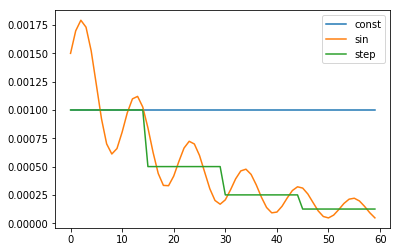

In [24]:
def clean_pytorch_dataloadergen(gen_iter):
    try:
        gen_iter._shutdown_workers()
        for _ in range(100):
            gen_iter.index_queue.put(None)
#         while not gen_iter.data_queue.empty():
#             b = gen_iter.data_queue.get()
        for w in gen_iter.workers:
            w.terminate()
        del gen_iter
    except ex:
        print(ex)


def const_lr(epoch, value=1e-3):
    return value


def step_annealed_lr(epoch, start=1e-3, step_epochs=15, decay_factor=0.5):
    lr_factor = decay_factor ** (epoch // step_epochs)
    return start * lr_factor


def sin_annealed_lr(epoch, freq=0.6, start=1e-3, sin_amp=5e-4, amp_decay_factor=0.97, mean_decay_factor=0.94, min_lr=1e-5):
    base = (numpy.sin(epoch * freq) + 1) * sin_amp * (amp_decay_factor ** epoch)
    mean = start * (mean_decay_factor ** epoch)
    return numpy.clip(base + mean, min_lr, None)


lr_vis_x = numpy.arange(0, 60, 1)
pandas.DataFrame(data=dict(const=const_lr(lr_vis_x),
                           step=step_annealed_lr(lr_vis_x),
                           sin=sin_annealed_lr(lr_vis_x))).plot()

### Run

#### Detect tables

In [25]:
# # %%prun

# train_gen = None
# val_gen = None

# EPOCHS_NUM = 30
# BATCH_SIZE = 1
# PART_PER_EPOCH = 0.2
# BATCHES_PER_EPOCH_TRAIN = int(len(train_det_image_ids) * PART_PER_EPOCH // BATCH_SIZE)
# BATCHES_PER_EPOCH_VAL = int(len(val_det_image_ids) * PART_PER_EPOCH // BATCH_SIZE)


# # det_net = UNet(out_channels=TOTAL_DET_CLASSES,
# #                first_conv_channels=7,
# #                depth=5,
# #                enc_dilations=[1, 2, 4, 8, 16, 32, 64]).cuda()
# det_net = RowCollAttUNet(out_channels=TOTAL_DET_CLASSES,
#                          first_conv_channels=6,
#                          depth=3,
#                          enc_dilations=[1, 2, 4, 8, 16, 32],
#                          dec_dilations=[1, 2, 4, 8, 16, 32]).cuda()
# LOSS = dice_bce_loss
# # LOSS = dice_loss
# # LOSS = weighted_dice_loss

# LR_SCHEDULE = step_annealed_lr
# # LR_SCHEDULE = sin_annealed_lr

# det_augmenter = imgaug_pipeline
# # det_augmenter = fake_imgaug_pipeline

# print('total parameters', sum(numpy.product(p.size()) for p in det_net.parameters()))

# train_metrics = []
# val_metrics = []
# for epoch in range(EPOCHS_NUM):
#     try:
#         train_gen = iter(DataLoader(SegmDataset(train_det_image_ids,
#                                                 det_augmenter,
#                                                 prepare_det_batch),
#                                     batch_size=BATCH_SIZE,
#                                     shuffle=True,
#                                     num_workers=4))
#         val_gen = iter(DataLoader(SegmDataset(val_det_image_ids,
#                                               det_augmenter,
#                                               prepare_det_batch),
#                                   batch_size=BATCH_SIZE,
#                                   shuffle=True,
#                                   num_workers=2))
#         print('epoch', epoch)

#         lr = LR_SCHEDULE(epoch)
#         print('lr', lr)
#         optimizer = Adam(det_net.parameters(), lr=lr)

#         det_net.train()
#         cur_train_metrics = run_network(det_net, train_gen, BATCHES_PER_EPOCH_TRAIN,
#                                         criterion=LOSS,
#                                         metrics=TRAIN_DET_METRICS,
#                                         optimizer=optimizer)
#         train_metrics.extend(cur_train_metrics)
#         display(pandas.DataFrame(cur_train_metrics).describe().loc[['mean', 'std']])

#         det_net.eval()
#         cur_val_metrics = run_network(det_net, val_gen, BATCHES_PER_EPOCH_VAL,
#                                       criterion=LOSS,
#                                       metrics=VAL_DET_METRICS)
#         val_metrics.extend(cur_val_metrics)
#         display(pandas.DataFrame(cur_val_metrics).describe().loc[['mean', 'std']])
#     finally:
#         if train_gen:
#             clean_pytorch_dataloadergen(train_gen)
#         if val_gen:
#             clean_pytorch_dataloadergen(val_gen)

#         gc.collect()

#### Segment structure

In [26]:
# train_gen = None
# val_gen = None

# EPOCHS_NUM = 40
# TRAIN_BATCH_SIZE = 16
# VAL_BATCH_SIZE = 1
# PART_PER_EPOCH = 0.1
# BATCHES_PER_EPOCH_TRAIN = int(len(train_int_image_ids) * PART_PER_EPOCH // TRAIN_BATCH_SIZE)
# BATCHES_PER_EPOCH_VAL = int(len(val_int_image_ids) * PART_PER_EPOCH // VAL_BATCH_SIZE)


# # net = StackedUNet1().cuda()
# # net = DenseNet1().cuda()

# net = UNet(first_conv_channels=6,
#            depth=4,
#            enc_dilations=[1, 2, 4, 8, 16, 32],
#            dec_dilations=[1]).cuda()
# # net = UNet(first_conv_channels=5,
# #                     depth=4,
# #                     enc_dilations=[1],
# #                     dec_dilations=[1],
# #                     out_dilations=[1]).cuda()
# # net = SimpleDenseNet(first_conv_channels=7,
# #                      depth=3,
# #                      enc_dilations=[1, 2, 4, 8, 16, 32, 64]).cuda()
# # net = SimpleDenseNetWithMean(first_conv_channels=5,
# #                              depth=6,
# #                              enc_dilations=[1, 2, 4, 8, 16]).cuda()
# # net = UNetWithMean(first_conv_channels=4,
# #                    depth=4,
# #                    enc_dilations=[1, 2, 4, 8],
# #                    dec_dilations=[1, 2, 4, 8]).cuda()

# LOSS = dice_bce_loss
# # LOSS = dice_loss
# # LOSS = weighted_dice_loss

# LR_SCHEDULE = step_annealed_lr
# # LR_SCHEDULE = sin_annealed_lr

# int_augmenter = imgaug_pipeline
# # int_augmenter = fake_imgaug_pipeline

# print('total parameters', sum(numpy.product(p.size()) for p in net.parameters()))

# train_metrics = []
# val_metrics = []
# for epoch in range(EPOCHS_NUM):
#     try:
#         train_gen = iter(DataLoader(SegmDataset(train_int_image_ids,
#                                                 int_augmenter,
#                                                 prepare_int_batch),
#                                     batch_size=TRAIN_BATCH_SIZE,
#                                     shuffle=True,
#                                     num_workers=4))
#         val_gen = iter(DataLoader(SegmDataset(val_int_image_ids,
#                                               int_augmenter,
#                                               prepare_int_batch),
#                                   batch_size=VAL_BATCH_SIZE,
#                                   shuffle=True,
#                                   num_workers=2))
#         print('epoch', epoch)

#         lr = LR_SCHEDULE(epoch)
#         print('lr', lr)
#         optimizer = Adam(net.parameters(), lr=lr)

#         net.train()
#         cur_train_metrics = run_network(net, train_gen, BATCHES_PER_EPOCH_TRAIN,
#                                         criterion=LOSS,
#                                         metrics=TRAIN_INT_METRICS,
#                                         optimizer=optimizer,
#                                         regularizer=row_col_smooth_contrast_reg)
#         train_metrics.extend(cur_train_metrics)
#         display(pandas.DataFrame(cur_train_metrics).describe().loc[['mean', 'std']])

#         net.eval()
#         cur_val_metrics = run_network(net, val_gen, BATCHES_PER_EPOCH_VAL,
#                                       criterion=LOSS,
#                                       metrics=VAL_INT_METRICS,
#                                       regularizer=row_col_smooth_contrast_reg)
#         val_metrics.extend(cur_val_metrics)
#         display(pandas.DataFrame(cur_val_metrics).describe().loc[['mean', 'std']])
#     finally:
#         if train_gen:
#             clean_pytorch_dataloadergen(train_gen)
#         if val_gen:
#             clean_pytorch_dataloadergen(val_gen)

#         gc.collect()

#### Structured End-to-End

In [27]:
# train_gen = None
# val_gen = None

# EPOCHS_NUM = 30
# BATCH_SIZE = 1
# PART_PER_EPOCH = 0.5
# BATCHES_PER_EPOCH_TRAIN = int(len(train_image_ids) * PART_PER_EPOCH // BATCH_SIZE)
# BATCHES_PER_EPOCH_VAL = int(len(val_image_ids) * PART_PER_EPOCH // BATCH_SIZE)

# net = TableSegmenter().cuda()
# RAW_LOSS = dice_loss
# print('total parameters', sum(numpy.product(p.size()) for p in net.parameters()))

# train_metrics = []
# val_metrics = []
# for epoch in range(EPOCHS_NUM):
#     try:
#         train_gen = iter(DataLoader(SegmDataset(train_image_ids, imgaug_pipeline, prepare_int_batch),
#                                     batch_size=BATCH_SIZE,
#                                     shuffle=True,
#                                     num_workers=4))
#         val_gen = iter(DataLoader(SegmDataset(val_image_ids, imgaug_pipeline, prepare_int_batch),
#                                   batch_size=BATCH_SIZE,
#                                   shuffle=True,
#                                   num_workers=2))
#         print('epoch', epoch)

#         lr_factor = 0.5 ** (epoch // 20)
#         lr = 1e-3 * lr_factor
#         print('lr', lr)
#         optimizer = Adam(net.parameters(), lr=lr)

#         net.train()
#         cur_train_metrics = run_network_structured(net, train_gen,
#                                                    BATCHES_PER_EPOCH_TRAIN,
#                                                    raw_criterion=RAW_LOSS,
#                                                    metrics=TRAIN_METRICS,
#                                                    optimizer=optimizer)
#         train_metrics.extend(cur_train_metrics)
#         display(pandas.DataFrame(cur_train_metrics).describe().loc[['mean', 'std']])

#         net.eval()
#         cur_val_metrics = run_network_structured(net, val_gen,
#                                                  BATCHES_PER_EPOCH_VAL,
#                                                  raw_criterion=RAW_LOSS,
#                                                  metrics=VAL_METRICS)
#         val_metrics.extend(cur_val_metrics)
#         display(pandas.DataFrame(cur_val_metrics).describe().loc[['mean', 'std']])
#     finally:
#         if train_gen:
#             clean_pytorch_dataloadergen(train_gen)
#         if val_gen:
#             clean_pytorch_dataloadergen(val_gen)

#         gc.collect()

#### Structured Two-step

In [28]:
# base_segm_model = torch.load('./models/segm_unet1_step_aug_full').cuda()

In [29]:
# base_train_gen = None
# base_val_gen = None

# EPOCHS_NUM = 30
# BASE_BATCH_SIZE = 4
# BATCH_SIZE = 10
# PART_PER_EPOCH = 0.05
# MEAN_RELS_PER_IMAGE = 2
# BATCHES_PER_EPOCH_TRAIN = int(len(train_int_image_ids) * PART_PER_EPOCH // BASE_BATCH_SIZE) * MEAN_RELS_PER_IMAGE
# BATCHES_PER_EPOCH_VAL = int(len(val_int_image_ids) * PART_PER_EPOCH // BASE_BATCH_SIZE) * MEAN_RELS_PER_IMAGE

# cell_net = ConvFCNClassifier(5, 2,
#                              conv_layers=3,
#                              dilations=[1, 2, 4, 8, 16, 32]).cuda()
# print('receptive field', cell_net.receptive_field)
# CELL_REL_LOSS = F.binary_cross_entropy
# print('total parameters', sum(numpy.product(p.size()) for p in cell_net.parameters()))

# # cell_tamper_channels = [0, 2, 3]
# cell_tamper_channels = []

# # cell_augmenter = imgaug_pipeline
# cell_augmenter = fake_imgaug_pipeline

# CELL_LR_SCHEDULE = step_annealed_lr

# train_metrics = []
# val_metrics = []
# for epoch in range(EPOCHS_NUM):
#     try:
#         base_train_gen = iter(DataLoader(SegmDataset(train_int_image_ids,
#                                                      cell_augmenter,
#                                                      prepare_int_batch),
#                                          batch_size=BASE_BATCH_SIZE,
#                                          shuffle=True,
#                                          num_workers=4))
#         train_gen = structured_two_step_datagen(base_train_gen,
#                                                 model=base_segm_model,
#                                                 cuda=True,
#                                                 batch_size=BATCH_SIZE,
#                                                 tamper_channels=cell_tamper_channels)
# #         qq = next(iter(train_gen))[0].data.cpu().numpy()
#         base_val_gen = iter(DataLoader(SegmDataset(val_int_image_ids,
#                                                    cell_augmenter,
#                                                    prepare_int_batch),
#                                        batch_size=BASE_BATCH_SIZE,
#                                        shuffle=True,
#                                        num_workers=2))
#         val_gen = structured_two_step_datagen(base_val_gen,
#                                               model=base_segm_model,
#                                               cuda=True,
#                                               batch_size=BATCH_SIZE,
#                                               tamper_channels=cell_tamper_channels)

#         print('epoch', epoch)

#         lr = CELL_LR_SCHEDULE(epoch)
#         print('lr', lr)
#         optimizer = Adam(cell_net.parameters(), lr=lr)

#         cell_net.train()
#         cur_train_metrics = run_cell_network(cell_net, train_gen, BATCHES_PER_EPOCH_TRAIN,
#                                              criterion=CELL_REL_LOSS,
#                                              metrics=CELL_TRAIN_METRICS,
#                                              optimizer=optimizer)
#         train_metrics.extend(cur_train_metrics)
#         display(pandas.DataFrame(cur_train_metrics).describe().loc[['mean', 'std']])

#         cell_net.eval()
#         cur_val_metrics = run_cell_network(cell_net, val_gen, BATCHES_PER_EPOCH_VAL,
#                                            criterion=CELL_REL_LOSS,
#                                            metrics=CELL_VAL_METRICS)
#         val_metrics.extend(cur_val_metrics)
#         display(pandas.DataFrame(cur_val_metrics).describe().loc[['mean', 'std']])
#     finally:
#         if base_train_gen:
#             clean_pytorch_dataloadergen(base_train_gen)
#         if base_val_gen:
#             clean_pytorch_dataloadergen(base_val_gen)

#         gc.collect()

### Plot metrics

In [30]:
# train_metrics = pandas.DataFrame(train_metrics)
# val_metrics = pandas.DataFrame(val_metrics)
# train_metrics.rolling(50).mean().plot(figsize=(13, 8), grid=True)
# val_metrics.rolling(50).mean().plot(figsize=(13, 8), grid=True)

## Predict and visualize

### Table detection

In [31]:
# torch.save(det_net, 'models/det_unet1_aug_ds2_aug_dil')

In [32]:
# det_test_net = det_net
det_test_net = torch.load('models/det_unet3_aug_ds2').cuda()

In [33]:
# det_test_gen = DataLoader(SegmDataset(val_det_image_ids,
# #                                       imgaug_pipeline,
#                                       fake_imgaug_pipeline,
#                                       prepare_det_batch),
#                           batch_size=1,
#                           shuffle=True,
#                           num_workers=0)

In [34]:
# det_test_metrics = pandas.DataFrame(run_network(det_test_net,
#                                                 det_test_gen,
#                                                 len(val_det_image_ids) // 4,
#                                                 metrics=VAL_DET_METRICS))
# format_metrics_table_md(det_test_metrics)

In [35]:
# det_test_batch = next(iter(det_test_gen))
# det_test_img = det_test_batch[1].cpu().numpy()
# det_test_mask = det_test_batch[2].cpu().numpy()
# det_test_pred = det_test_net(npvar(det_test_batch[1], True))
# det_test_pred_np = det_test_pred.cpu().data.numpy()

In [36]:
# arr_to_img(det_test_img[2][0])

In [37]:
# arr_to_img(mask_to_img(det_test_mask[0]))

In [38]:
# arr_to_img(mask_to_img(det_test_pred_np[2]))

In [39]:
# arr_to_img(mask_to_img(fill_boxes_on_mask_single_image(det_test_pred_np[2])))

#### Results


##### Trained Without Augmentation

###### U-net1+step

|         | bd        | d         | loss      | px_p      | px_r      |
|:--------|:----------|:----------|:----------|:----------|:----------|
| body    | 0.90±0.10 | 0.90±0.10 |           | 0.91±0.12 | 0.92±0.11 |
| caption | 0.76±0.18 | 0.75±0.18 |           | 0.79±0.17 | 0.79±0.21 |
| loss    |           |           | 0.21±0.24 |           |           |

###### DenseNet1


##### Trained With Augmentation

###### U-net1+step

|         | bd        | d         | loss      | px_p      | px_r      |
|:--------|:----------|:----------|:----------|:----------|:----------|
| body    | 0.90±0.10 | 0.89±0.10 |           | 0.93±0.11 | 0.88±0.12 |
| caption | 0.72±0.20 | 0.66±0.20 |           | 0.81±0.19 | 0.62±0.24 |
| loss    |           |           | 0.25±0.24 |           |           |


###### U-net2+step+new dataset

|         | bd        | d         | loss      | px_p      | px_r      |
|:--------|:----------|:----------|:----------|:----------|:----------|
| body    | 0.89±0.10 | 0.89±0.10 |           | 0.92±0.12 | 0.89±0.11 |
| caption | 0.76±0.16 | 0.74±0.17 |           | 0.83±0.16 | 0.74±0.20 |
| value   |           |           | 0.23±0.22 |           |           |

###### det_unet3_aug_ds2

|         | bd        | d         | loss      | px_p      | px_r      |
|:--------|:----------|:----------|:----------|:----------|:----------|
| body    | 0.90±0.10 | 0.89±0.10 |           | 0.93±0.12 | 0.90±0.11 |
| caption | 0.78±0.16 | 0.79±0.16 |           | 0.85±0.15 | 0.80±0.20 |
| value   |           |           | 0.21±0.23 |           |           |

###### det_attnet1_aug_ds2

|         | bd        | d         | loss      | px_p      | px_r      |
|:--------|:----------|:----------|:----------|:----------|:----------|
| body    | 0.85±0.21 | 0.84±0.20 |           | 0.87±0.22 | 0.88±0.20 |
| caption | 0.68±0.32 | 0.64±0.30 |           | 0.73±0.34 | 0.67±0.31 |
| value   |           |           | 0.43±0.96 |           |           |


#### Old Results

##### torch4_net
	d body	d caption	loss
    mean	0.889029	0.724086	0.238287
    std	0.104200	0.185334	0.262712

### Table structure segmentation

In [40]:
# torch.save(net, 'models/segm_unet1_step_aug_full2_rc_sc_reg')

In [41]:
# test_net = net

In [42]:
test_net = torch.load('models/segm_unet1_step_aug_full2_rc_sc_reg').cuda()

In [43]:
# test_gen = DataLoader(SegmDataset(val_int_image_ids,
#                                   imgaug_pipeline,
# #                                   fake_imgaug_pipeline,
#                                   prepare_int_batch),
#                       batch_size=1,
#                       shuffle=True,
#                       num_workers=0)

In [44]:
# test_metrics = pandas.DataFrame(run_network(test_net,
#                                             test_gen,
#                                             len(val_int_image_ids),
#                                             metrics=TEST_INT_METRICS))
# format_metrics_table_md(test_metrics)

In [45]:
# test_iter = iter(test_gen)

In [46]:
# test_batch = next(test_iter)
# test_pred = test_net(npvar(test_batch[1], True))
# test_pred_np = test_pred.cpu().data.numpy()

In [47]:
# arr_to_img(test_batch[1][0][0].cpu().numpy())

In [48]:
# arr_to_img(mask_to_img(test_pred_np[0]))

In [49]:
# arr_to_img(mask_to_img(test_batch[2][0].cpu().numpy()))

#### Results


##### Trained Without Augmentation

###### U-net1+step

*Eval With Augmentation*

|                    | bf        | bp        | br        | d         | loss      |
|:-------------------|:----------|:----------|:----------|:----------|:----------|
| body               | 0.00±0.00 | 0.00±0.00 | 0.00±0.00 | 0.86±0.05 |           |
| cell               | 0.43±0.20 | 0.60±0.25 | 0.38±0.19 | 0.47±0.19 |           |
| loss               |           |           |           |           | 1.33±0.45 |
| same_col_other_row | 0.01±0.03 | 0.06±0.10 | 0.01±0.02 | 0.37±0.18 |           |
| same_row_other_col | 0.01±0.02 | 0.03±0.09 | 0.00±0.02 | 0.50±0.17 |           |

*Eval Without Augmentation*

|                    | bf        | bp        | br        | d         | loss      |
|:-------------------|:----------|:----------|:----------|:----------|:----------|
| body               | 0.00±0.00 | 0.00±0.00 | 0.00±0.00 | 1.00±0.00 |           |
| cell               | 0.97±0.02 | 1.00±0.01 | 0.95±0.03 | 0.96±0.00 |           |
| loss               |           |           |           |           | 0.11±0.02 |
| same_col_other_row | 0.01±0.02 | 0.02±0.07 | 0.00±0.01 | 0.87±0.02 |           |
| same_row_other_col | 0.02±0.04 | 0.10±0.16 | 0.01±0.02 | 0.91±0.01 |           |

###### DenseNet1+step

*Eval With Augmentation*

*Eval Without Augmentation*

|                    | bf        | bp        | br        | d         | loss      |
|:-------------------|:----------|:----------|:----------|:----------|:----------|
| body               | 0.00±0.00 | 0.00±0.00 | 0.00±0.00 | 0.98±0.01 |           |
| cell               | 0.97±0.02 | 1.00±0.01 | 0.95±0.03 | 0.93±0.01 |           |
| loss               |           |           |           |           | 0.32±0.02 |
| same_col_other_row | 0.00±0.00 | 0.00±0.00 | 0.00±0.00 | 0.27±0.01 |           |
| same_row_other_col | 0.13±0.08 | 0.50±0.23 | 0.08±0.05 | 0.64±0.02 |           |


##### Trained With Augmentation

###### U-net1+step

*Eval With Augmentation*

|                    | bf        | bp        | br        | d         | loss      |
|:-------------------|:----------|:----------|:----------|:----------|:----------|
| body               | 0.00±0.00 | 0.00±0.00 | 0.00±0.00 | 0.99±0.01 |           |
| cell               | 0.92±0.06 | 0.91±0.07 | 0.95±0.08 | 0.91±0.03 |           |
| same_col_other_row | 0.07±0.15 | 0.20±0.40 | 0.04±0.11 | 0.81±0.06 |           |
| same_row_other_col | 0.20±0.26 | 0.48±0.50 | 0.14±0.21 | 0.82±0.11 |           |
| value              |           |           |           |           | 0.20±0.11 |

##### Combined Dataset (full)

###### U-Net1

|                    | bf        | bp        | br        | d         | loss      |
|:-------------------|:----------|:----------|:----------|:----------|:----------|
| body               | 0.00±0.00 | 0.00±0.00 | 0.00±0.00 | 1.00±0.00 |           |
| cell               | 0.96±0.05 | 0.96±0.04 | 0.96±0.07 | 0.94±0.02 |           |
| same_col_other_row | 0.04±0.12 | 0.13±0.34 | 0.03±0.08 | 0.85±0.05 |           |
| same_row_other_col | 0.09±0.19 | 0.28±0.45 | 0.06±0.14 | 0.88±0.04 |           |
| value              |           |           |           |           | 0.14±0.05 |


###### DenseNet2

|                    | bf        | bp        | br        | d         | loss      |
|:-------------------|:----------|:----------|:----------|:----------|:----------|
| body               | 0.00±0.00 | 0.00±0.00 | 0.00±0.00 | 0.99±0.01 |           |
| cell               | 0.93±0.05 | 0.91±0.07 | 0.96±0.06 | 0.93±0.02 |           |
| same_col_other_row | 0.30±0.30 | 0.59±0.49 | 0.22±0.24 | 0.80±0.06 |           |
| same_row_other_col | 0.43±0.29 | 0.83±0.37 | 0.32±0.26 | 0.80±0.08 |           |
| value              |           |           |           |           | 0.18±0.07 |

###### segm_densenetmean1_step_aug_full

|                    | bf        | bp        | br        | d         | loss      |
|:-------------------|:----------|:----------|:----------|:----------|:----------|
| body               | 0.00±0.00 | 0.00±0.00 | 0.00±0.00 | 0.76±0.22 |           |
| cell               | 0.93±0.12 | 0.91±0.12 | 0.95±0.12 | 0.86±0.15 |           |
| same_col_other_row | 0.21±0.26 | 0.48±0.50 | 0.15±0.20 | 0.63±0.20 |           |
| same_row_other_col | 0.29±0.30 | 0.61±0.49 | 0.22±0.25 | 0.57±0.28 |           |
| value              |           |           |           |           | 1.47±1.78 |

###### segm_unetmean1_step_aug_full

|                    | bf        | bp        | br        | d         | loss      |
|:-------------------|:----------|:----------|:----------|:----------|:----------|
| body               | 0.00±0.00 | 0.00±0.00 | 0.00±0.00 | 0.72±0.29 |           |
| cell               | 0.83±0.24 | 0.79±0.25 | 0.89±0.24 | 0.76±0.24 |           |
| same_col_other_row | 0.19±0.26 | 0.40±0.48 | 0.14±0.21 | 0.60±0.24 |           |
| same_row_other_col | 0.24±0.28 | 0.55±0.49 | 0.17±0.23 | 0.67±0.26 |           |
| value              |           |           |           |           | 1.71±3.18 |

###### segm_unetmean2_step_aug_full_shrinked_reweighted_cells_only_dec_dil

|                    | bf        | bp        | br        | d         | loss      | px_p      | px_r      |
|:-------------------|:----------|:----------|:----------|:----------|:----------|:----------|:----------|
| body               | 0.00±0.00 | 0.00±0.00 | 0.00±0.00 | 0.95±0.12 |           | 0.00±0.00 | 0.00±0.00 |
| cell               | 0.91±0.19 | 0.93±0.20 | 0.91±0.16 | 0.89±0.15 |           | 0.89±0.17 | 0.95±0.03 |
| same_col_other_row | 0.00±0.00 | 0.00±0.00 | 0.00±0.00 | 0.97±0.10 |           | 0.00±0.00 | 0.00±0.00 |
| same_row_other_col | 0.00±0.00 | 0.00±0.00 | 0.00±0.00 | 0.93±0.16 |           | 0.00±0.00 | 0.00±0.00 |
| value              |           |           |           |           | 0.36±0.85 |           |           |

###### segm_unet3_step_aug_full_shrinked_reweighted_cells_only_dec_dil_out

|                    | bf        | bp        | br        | d         | loss      | px_p      | px_r      |
|:-------------------|:----------|:----------|:----------|:----------|:----------|:----------|:----------|
| body               | 0.00±0.00 | 0.00±0.00 | 0.00±0.00 | 0.88±0.12 |           | 0.00±0.00 | 0.00±0.00 |
| cell               | 0.95±0.06 | 0.97±0.05 | 0.94±0.09 | 0.93±0.03 |           | 0.94±0.03 | 0.95±0.03 |
| same_col_other_row | 0.00±0.00 | 0.00±0.00 | 0.00±0.00 | 0.72±0.18 |           | 0.00±0.00 | 0.00±0.00 |
| same_row_other_col | 0.00±0.00 | 0.00±0.00 | 0.00±0.00 | 0.83±0.15 |           | 0.00±0.00 | 0.00±0.00 |
| value              |           |           |           |           | 0.17±0.08 |           |           |


##### Full2 (with big_simple)

###### segm_unet1_step_aug_full2

|                    | bf        | bp        | br        | d         | loss      | px_p      | px_r      |
|:-------------------|:----------|:----------|:----------|:----------|:----------|:----------|:----------|
| body               | 0.00±0.00 | 0.00±0.00 | 0.00±0.00 | 0.89±0.13 |           | 0.00±0.00 | 0.00±0.00 |
| cell               | 0.96±0.05 | 0.99±0.03 | 0.94±0.08 | 0.93±0.02 |           | 0.95±0.03 | 0.94±0.03 |
| same_col_other_row | 0.00±0.00 | 0.00±0.00 | 0.00±0.00 | 0.95±0.09 |           | 0.00±0.00 | 0.00±0.00 |
| same_row_other_col | 0.00±0.00 | 0.00±0.00 | 0.00±0.00 | 0.92±0.08 |           | 0.00±0.00 | 0.00±0.00 |
| value              |           |           |           |           | 0.17±0.07 |           |           |

###### segm_unet1_step_aug_full2_rc_sc_reg (best actually!)

|                    | bf        | bp        | br        | d         | loss      | px_p      | px_r      |
|:-------------------|:----------|:----------|:----------|:----------|:----------|:----------|:----------|
| body               | 0.00±0.00 | 0.00±0.00 | 0.00±0.00 | 1.00±0.00 |           | 0.00±0.00 | 0.00±0.00 |
| cell               | 0.95±0.05 | 0.98±0.04 | 0.93±0.09 | 0.92±0.02 |           | 0.93±0.03 | 0.94±0.03 |
| same_col_other_row | 0.00±0.00 | 0.00±0.00 | 0.00±0.00 | 1.00±0.00 |           | 0.00±0.00 | 0.00±0.00 |
| same_row_other_col | 0.00±0.00 | 0.00±0.00 | 0.00±0.00 | 0.99±0.00 |           | 0.00±0.00 | 0.00±0.00 |
| value              |           |           |           |           | 0.20±0.07 |           |           |

### Intracell classification (second step)

In [50]:
# torch.save(cell_net, './models/cell_fcn1_no_aug_diag_with_unet1')

In [51]:
cell_test_net = torch.load('models/cell_fcn1_no_aug_diag_with_unet1').cuda()
cell_test_base_segm_model = torch.load('models/segm_unet1_step_aug_full2_rc_sc_reg').cuda()

In [52]:
# cell_test_gen = structured_two_step_datagen(DataLoader(SegmDataset(val_int_image_ids,
#                                                                    imgaug_pipeline,
# #                                                                    fake_imgaug_pipeline,
#                                                                    prepare_int_batch),
#                                                        batch_size=4,
#                                                        shuffle=True,
#                                                        num_workers=0),
#                                             model=cell_test_base_segm_model,
#                                             cuda=True,
#                                             batch_size=10, 
#                                             tamper_channels=[])

In [53]:
# cell_test_metrics = pandas.DataFrame(run_cell_network(cell_test_net,
#                                                       cell_test_gen,
#                                                       1000,
#                                                       metrics=CELL_TRAIN_METRICS))
# format_metrics_table_md(cell_test_metrics)

In [54]:
# cell_test_iter = iter(cell_test_gen)

In [55]:
# cell_test_batch = next(cell_test_iter)

# cell_test_pred = cell_test_net(cell_test_batch[0])
# cell_test_pred_np = cell_test_pred.cpu().data.numpy()

# cell_test_in_np = cell_test_batch[0].data.cpu().numpy()
# cell_test_gold_np = cell_test_batch[1].data.cpu().numpy()

In [56]:
# cell_test_cls = 0
# cell_err_idx = numpy.where((cell_test_pred_np[:, cell_test_cls] > 0.5) ^ (cell_test_gold_np[:, cell_test_cls] > 0.5))[0]
# cell_err_idx

In [57]:
# arr_to_img(mask_to_img(cell_test_in_np[3]))

In [58]:
# numpy.stack([cell_test_pred_np, cell_test_gold_np])

#### Results

##### Trained Without Augmentation



###### cell_fcn1_no_aug + segm_unet1_step_aug dirty

*eval no aug*

|          | f1        | loss      | p         | r         |
|:---------|:----------|:----------|:----------|:----------|
| loss     |           | 0.12±0.17 |           |           |
| same_col | 0.98±0.07 |           | 0.97±0.10 | 0.99±0.03 |
| same_row | 0.98±0.05 |           | 1.00±0.02 | 0.97±0.08 |


*eval with aug*

|          | f1        | loss      | p         | r         |
|:---------|:----------|:----------|:----------|:----------|
| loss     |           | 0.12±0.19 |           |           |
| same_col | 0.97±0.07 |           | 0.96±0.10 | 0.99±0.03 |
| same_row | 0.98±0.05 |           | 0.99±0.03 | 0.97±0.08 |

###### cell_fcn1_no_aug + segm_unet1_step_aug clean

*eval no aug*

|          | f1        | loss      | p         | r         |
|:---------|:----------|:----------|:----------|:----------|
| loss     |           | 0.06±0.09 |           |           |
| same_col | 0.99±0.04 |           | 0.99±0.06 | 1.00±0.02 |
| same_row | 0.99±0.03 |           | 1.00±0.02 | 0.99±0.04 |


*eval with aug*

|          | f1        | loss      | p         | r         |
|:---------|:----------|:----------|:----------|:----------|
| loss     |           | 0.08±0.16 |           |           |
| same_col | 0.99±0.05 |           | 0.98±0.06 | 1.00±0.02 |
| same_row | 0.98±0.04 |           | 0.98±0.06 | 0.99±0.05 |


##### Trained With Augmentation

## Parse tables using all built models

In [59]:
def reorder_cells(c1, c2, cells, dim):
    b1, b2 = cells[c1], cells[c2]
    coord1, coord2 = b1[dim], b2[dim]
    coord1o, coord2o = b1[dim+2], b2[dim+2]
    if coord1 < coord2:
        return c1, c2, coord2 > coord1o
    else:
        return c2, c1, coord1 > coord2o


class SeqIdGen(object):
    def __init__(self):
        self.next_id = 0

    def __call__(self):
        res = self.next_id
        self.next_id += 1
        return res


def make_equivalence_classes(neighborhood):
    cell2cls = {}
    gen_cls_id = SeqIdGen()

    refs_by_cell = { c : 0
                    for cur_cell, neighs in neighborhood.items()
                    for lst in ((cur_cell,), neighs)
                    for c in lst }
    for cur_cell, neighs in neighborhood.items():
        for oc in neighs:
            refs_by_cell[oc] += 1
    cells_with_no_refs = [c
                          for c, refs_n in refs_by_cell.items()
                          if refs_n == 0]

    for cls_seed in cells_with_no_refs:
        cur_queue = collections.deque([(cls_seed, { gen_cls_id() })])

        while len(cur_queue) > 0:
            cur_cell, cur_cls = cur_queue.popleft()
            cell2cls[cur_cell] = cur_cls

            cur_neighbors = neighborhood.get(cur_cell, [])
            many_neighbors = len(cur_neighbors) > 1
            for oc in cur_neighbors:
                oc_cls = set(cur_cls)
                if many_neighbors:
                    oc_cls.add(gen_cls_id())
                cur_queue.append((oc, oc_cls))

    cls2cell = collections.defaultdict(set)
    for cell, classes in cell2cls.items():
        for cls in classes:
            cls2cell[cls].add(cell)
    classes_to_remove = {cls
                         for cls, cells in cls2cell.items()
                         if len(cells) == 1 and all(len(cell2cls[c]) > 1 for c in cells)}
    for cls in classes_to_remove:
        for cell in cls2cell[cls]:
            cell2cls[cell].remove(cls)
        del cls2cell[cls]

    return cell2cls


RECONST_SAME_ROW_NEIGH = {'left', 'right'}
RECONST_SAME_COL_NEIGH = {'upper', 'lower'}
def reconstruct_table_from_grid(body, cells, grid, cell_idx, intracell_space_classes, prob_threshold=0.3):
    row_neighbors = collections.defaultdict(set)
    col_neighbors = collections.defaultdict(set)

    for (c1, c2), (neigh_type, probs) in intracell_space_classes.items():
        b1 = cells[c1]
        b2 = cells[c2]
        if (neigh_type in RECONST_SAME_ROW_NEIGH) or (probs[STRUCT_SAME_ROWS_I] > prob_threshold):
            rc1, rc2, do_not_overlap = reorder_cells(c1, c2, cells, 1) # ensure rc1 is in the left of rc2
            if do_not_overlap:
                row_neighbors[rc1].add(rc2)
        if (neigh_type in RECONST_SAME_COL_NEIGH) or (probs[STRUCT_SAME_COLS_I] > prob_threshold):
            cc1, cc2, do_not_overlap = reorder_cells(c1, c2, cells, 0) # ensure cc1 is above of cc2
            if do_not_overlap:
                col_neighbors[cc1].add(cc2)

    cell2rows = make_equivalence_classes(row_neighbors)
    cell2cols = make_equivalence_classes(col_neighbors)

    rows = collections.defaultdict(set)
    for cell_i, cell_rows_idx in cell2rows.items():
        for row_i in cell_rows_idx:
            rows[row_i].add(cell_i)

    cols = collections.defaultdict(set)
    for cell_i, cell_cols_idx in cell2cols.items():
        for col_i in cell_cols_idx:
            cols[col_i].add(cell_i)

    row_boxes = [just_box_union([cells[i] for i in row_idx])
                 for row_idx in rows.values()]
    row_boxes.sort(key=lambda b: b[0])

    col_boxes = [just_box_union([cells[i] for i in col_idx])
                 for col_idx in cols.values()]
    col_boxes.sort(key=lambda b: b[1])
    return (body,
            cells,
            row_boxes,
            col_boxes)


def get_segm_mask_batch(images, segm_model, cuda=True):
    batch_segm_input = npvar(numpy.expand_dims(numpy.array([numpy.array(img).astype('float32')
                                                            for img in images]),
                                               1) / 255.0,
                             cuda)
    out = segm_model(batch_segm_input)
    if isinstance(out, tuple):
        out = out[0]
    return out.data.cpu().numpy()


# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# подключить det_model
# копировать выделенные фрагменты в отдельные картинки и их сегментировать с помощью segm_model


def ceil_mod(x, mod):
    if x % mod == 0:
        return x
    return ((x // mod) + 1) * mod


def choose_image_size_multiple_of(min_size, multiplier=32):
    return (ceil_mod(min_size[0], multiplier),
            ceil_mod(min_size[1], multiplier))


def fit_image_size(src_image, multiplier=128, mode='L', filler=255):
    new_size = choose_image_size_multiple_of(src_image.size,
                                             multiplier=multiplier)
    result = Image.new(mode,
                       new_size,
                       filler)
    result.paste(src_image)
    return result


def box_to_abs_coords(box, parent):
    py1, px1, py2, px2 = parent
    by1, bx1, by2, bx2 = box
    return (by1+py1, bx1+px1, by2+py1, bx2+px1)


def box_lst_to_abs_coords(boxes, parent):
    return [box_to_abs_coords(box, parent) for box in boxes]


def preprocess_page_image(img, kernel=11, ):
    img_arr = numpy.array(img)
    bin_arr = cv2.adaptiveThreshold(img_arr,
                                    255,
                                    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY,
                                    5,
                                    20)
    return Image.fromarray(bin_arr)


# CELL_OPEN_H_MASK = numpy.ones((3, 5), dtype='uint8')
# CELL_OPEN_V_MASK = numpy.ones((5, 3), dtype='uint8')
# CELL_DIL_H_MASK = numpy.ones((1, 3), dtype='uint8')
# CELL_DIL_V_MASK = numpy.ones((3, 1), dtype='uint8')
CELL_OPEN_MASK = numpy.ones((5, 5), dtype='uint8')
CELL_ERODE_MASK = numpy.ones((3, 1), dtype='uint8')
def postprocess_segm_mask(mask):
    cell_mask = (mask[1] * 255).astype('uint8')

    for box in filter_boxes_by_overlap(get_all_boxes(mask[1])):
        y1, x1, y2, x2 = box
        if box_area(box) <= 15 or y2-y1 <= 9 or x2-x1 <= 9:
            continue
        box_mask = cell_mask[y1:y2+1, x1:x2+1]
        box_mask = cv2.erode(box_mask, CELL_ERODE_MASK)
        box_mask = cv2.morphologyEx(box_mask, cv2.MORPH_OPEN, CELL_OPEN_MASK)
        cell_mask[y1:y2+1, x1:x2+1] = box_mask

    result = mask.copy()
    result[1] = cell_mask.astype('float32') / 255
    return result


def extend_img_with_means(img):
    img = numpy.array(img)
    rows_mean = numpy.repeat(numpy.expand_dims(img.mean(0), 0),
                             img.shape[0],
                             axis=0)
    cols_mean = numpy.repeat(numpy.expand_dims(img.mean(1), 1),
                             img.shape[1],
                             axis=1)
    return numpy.stack([img, rows_mean, cols_mean])


def postprocess_densecrf(input_img, mask):
    input_img = numpy.array(input_img)
    d = dcrf.DenseCRF2D(mask.shape[0], mask.shape[1], 2)
    
    # account for predicted mask
    unary = numpy.zeros((2, mask.shape[0], mask.shape[1]),
                        dtype='float32')
    unary[0] = mask
    unary[1] = 1 - mask
    unary = -numpy.log(unary)
    d.setUnaryEnergy(unary.reshape((2, -1)))

    # account for adjacency
#     d.addPairwiseGaussian(sxy=(3, 3),
#                           compat=1,
#                           kernel=dcrf.DIAG_KERNEL,
#                           normalization=dcrf.NORMALIZE_SYMMETRIC)

    # account for pixel-level box-relatedness
    boxes = get_all_boxes(mask)
    px_row_boxes = numpy.zeros((mask.shape[0], mask.shape[1], len(boxes)), dtype='float32')
    px_col_boxes = numpy.zeros((mask.shape[0], mask.shape[1], len(boxes)), dtype='float32')
    for box_i, (y1, x1, y2, x2) in enumerate(boxes):
        px_row_boxes[y1:y2+1, :, box_i] = 1
        px_col_boxes[:, x1:x2+1, box_i] = 1

    px_row_energy = create_pairwise_bilateral(sdims=(1.0, 1.0),
                                              schan=numpy.ones(len(boxes), dtype='float32'),
                                              img=px_row_boxes,
                                              chdim=2)
    px_col_energy = create_pairwise_bilateral(sdims=(1.0, 1.0),
                                              schan=numpy.ones(len(boxes), dtype='float32'),
                                              img=px_col_boxes,
                                              chdim=2)
    d.addPairwiseEnergy(px_row_energy, compat=10)
    d.addPairwiseEnergy(px_col_energy, compat=10)

    pred = numpy.array(d.inference(50))
    pred = pred.reshape((2, mask.shape[0], mask.shape[1]))
    return pred[0]


def remove_too_close_points_inner(lst, th=0.8):
    result = []
    last_group = [lst[0]]
    for cur in lst[1:]:
        if cur - last_group[-1] < th:
            last_group.append(cur)
        else:
            
            if last_group:
                result.append(last_group)
            last_group = [cur]
    if last_group:
        result.append(last_group)
    return [int(round(numpy.mean(group))) for group in result]


def remove_too_close_points(lst, th=1.1, max_iter=2):
    if not lst:
        return lst
    new_lst = lst
    for _ in range(max_iter):
        new_lst = remove_too_close_points_inner(lst, th=th)
        if len(new_lst) == len(lst):
            break
        lst = new_lst
    return new_lst


def make_superpixels_grid(mask, boxes_th=1.01):
    ys = [0]
    xs = [0]
    for (y1, x1, y2, x2) in get_all_boxes(mask):
        ys.append(y1)
        ys.append(y2)
        xs.append(x1)
        xs.append(x2)
    ys.append(mask.shape[0])
    xs.append(mask.shape[1])
    ys.sort()
    xs.sort()
    ys = remove_too_close_points(ys, th=boxes_th)
    xs = remove_too_close_points(xs, th=boxes_th)
    boxes = [(ys[i], xs[j], ys[i+1], xs[j+1])
             for i in range(len(ys) - 1)
             for j in range(len(xs) - 1)]
    return boxes


_HIST_FILTER_BINS = numpy.arange(0, 1.0001, 30)
def make_hist_filter(xs, bins=_HIST_FILTER_BINS, min_val=3e-2, min_perc=0.25):
    sorted_xs = sorted(xs)
    min_pos = min_perc * len(sorted_xs)
    xs = [(x >= min_val) and (bisect.bisect_left(sorted_xs, x) >= min_pos)
          for x in xs]
    return numpy.array(xs)


def remove_false_in_line(arr, window=1):
    return numpy.array([arr[i:i+window+1].any() for i in range(len(arr))])


def filter_by_row_col_stat(src_img, mask, max_iter=3, min_diff=1, true_window_to_ignore=1):
    src_row_labels = remove_false_in_line(make_hist_filter(1 - src_img.mean(1)),
                                          window=true_window_to_ignore)
    src_col_labels = remove_false_in_line(make_hist_filter(1 - src_img.mean(0)),
                                          window=true_window_to_ignore)
    for _ in range(max_iter):
        row_labels = remove_false_in_line(make_hist_filter(mask.mean(1)),
                                          window=true_window_to_ignore)
        row_labels |= src_row_labels
        col_labels = remove_false_in_line(make_hist_filter(mask.mean(0)),
                                          window=true_window_to_ignore)
        col_labels |= src_col_labels

        new_mask = mask.copy()
        new_mask[~row_labels, :] = 0
        new_mask[:, ~col_labels] = 0
        if (mask - new_mask).sum() < min_diff:
            return new_mask
        mask = new_mask
    return mask


SPARSE_CLOSE_KERNEL = numpy.ones((1, 1), dtype='uint8')
def smooth_sparse_mask(mask):
    img = (mask * 255).astype('uint8')
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, SPARSE_CLOSE_KERNEL)
    return img.astype('float32') / 255


def postprocess_using_superpixels(src_img, cells_mask):
    cells_mask_sparse = filter_by_row_col_stat(src_img, postprocess_segm_mask(cells_mask))
    orig_superpixels = make_superpixels_grid(cells_mask_sparse)
    superpixels = filter_boxes_by_real_pixels(orig_superpixels, src_img)
    removed_boxes = set(orig_superpixels) - set(superpixels)
    for y1, x1, y2, x2 in removed_boxes:
        cells_mask_sparse[y1:y2+1, x1:x2+1] = 0
    return cells_mask_sparse


def parse_tables_from_images(images, det_model, segm_model, cell_model,
                             cuda=True, cell_batch_size=64, min_body_area=300,
                             body_padding=0, demo_prefix=None, display_demo=False,
                             box_content_getter=None, cell_content_filter=None, table_regions_by_image=None):
    tables_by_image = []
    grids_by_image = []

    images = [preprocess_page_image(img) for img in images]
    batch_det_output = get_segm_mask_batch(images, det_model, cuda)
    batch_det_output = fill_boxes_on_mask_batch(batch_det_output)
    for page_no, (src_image, det_mask) in enumerate(zip(images, batch_det_output)):
        cur_img_tables = []
        cur_img_grids = []

        if demo_prefix or display_demo:
            demo = arr_to_img(mask_to_img(det_mask))
            if display_demo:
                display(demo)
            if demo_prefix:
                demo.save(demo_prefix + '-det.png')
        det_boxes_by_channel = get_boxes_by_channel(det_mask)

        cur_image_captions = det_boxes_by_channel[DET_CAPTION_CHANNEL_I]
        if table_regions_by_image:
            cur_image_bodies = table_regions_by_image[page_no]
        else:
            cur_image_bodies = det_boxes_by_channel[DET_BODY_CHANNEL_I]
            cur_image_bodies.sort(key=box_area, reverse=True)
        for body_i, body in enumerate(cur_image_bodies):
            if box_area(body) < min_body_area:
                continue
            ext_body = (max(0, body[0]-body_padding),
                        max(0, body[1]-body_padding),
                        min(src_image.size[1], body[2]+body_padding),
                        min(src_image.size[0], body[3]+body_padding))
            cropped_image = src_image.crop((ext_body[1], ext_body[0], ext_body[3], ext_body[2]))
            src_image_for_segm = fit_image_size(cropped_image)
            src_image_for_segm_arr = numpy.array(src_image_for_segm).astype('float32') / 255.0
            segm_output = get_segm_mask_batch([src_image_for_segm], segm_model, cuda)[0]
#             return src_image_for_segm, segm_output
#             segm_output = postprocess_segm_mask(segm_output)
#             segm_output_cells = postprocess_using_superpixels(src_image_for_segm_arr,
#                                                               segm_output[1])
#             segm_output_cells = postprocess_segm_mask(segm_output_cells)
#             segm_output[1] = segm_output_cells

            if demo_prefix or display_demo:
                demo = arr_to_img(mask_to_img(segm_output))
                if display_demo:
                    display(demo)
                if demo_prefix:
                    demo.save(demo_prefix + '-segm-{}.png'.format(body_i))

            # here should go a loop over all found bodies
            _, cells, grid, cell_idx, intracell_relations = table_grid_from_intracell_mask(segm_output,
                                                                                           input_image=src_image_for_segm_arr,
                                                                                           box_content_getter=(lambda box: box_content_getter(page_no,
                                                                                                                                              box_to_abs_coords(box, ext_body)))
                                                                                               if box_content_getter else None,
                                                                                           content_filter=cell_content_filter)
            output_cell_coords = box_lst_to_abs_coords(cells, ext_body)
            intracell_relation_keys = list(intracell_relations.keys())
            intracell_relation_classes = {}
            for batch_start in range(0, len(intracell_relation_keys), cell_batch_size):
                batch_rel_keys = intracell_relation_keys[batch_start:batch_start+cell_batch_size]
                batch_relations = [(cells[i1], cells[i2], intracell_relations[(i1, i2)])
                                   for (i1, i2) in batch_rel_keys]

                cell_img_inp = npvar(segm_output, cuda).unsqueeze(0)
                cell_batch_input = CellRelConvFCNClassifier.make_batch(cell_img_inp,
                                                                       [batch_relations])
                cell_batch_output = cell_model(cell_batch_input).data.cpu().numpy()
                for rel_key, cur_cell_pair_out in zip(batch_rel_keys, cell_batch_output):
                    intracell_relation_classes[rel_key] = (intracell_relations[rel_key], cur_cell_pair_out)
            cur_img_grids.append((body, output_cell_coords, grid, cell_idx, intracell_relation_classes))
            cur_table = reconstruct_table_from_grid(body, output_cell_coords, grid, cell_idx, intracell_relation_classes)
            if len(cur_table[2]) > 1 and len(cur_table[3]) > 1:
                cur_img_tables.append(cur_table)

        tables_by_image.append(cur_img_tables)
        grids_by_image.append(cur_img_grids)
        
        if demo_prefix or display_demo:
            for table_i, table in enumerate(cur_img_tables):
                demo = make_demo_mask_from_parsed_table(src_image, table)
                if display_demo:
                    display(demo)
                if demo_prefix:
                    demo.save(demo_prefix + '-table-{}.png'.format(table_i))

    return tables_by_image, grids_by_image


def make_boxes_with_channels_from_parsed_table(table_info):
    body, cells, rows, cols = table_info
    boxes = [(1, body)]
    boxes.extend((2, b) for b in cells)
    boxes.extend((3, b) for b in rows)
    boxes.extend((4, b) for b in cols)
    return boxes


def make_demo_mask_from_parsed_table(img, table_info):
    boxes = make_boxes_with_channels_from_parsed_table(table_info)
    return make_demo_mask(img, boxes)


def make_intracell_rels_symmetric(intracell_relation_classes):
    src_keys = list(intracell_relation_classes.keys())
    sums = collections.defaultdict(lambda: numpy.zeros(2, dtype='float32'))
    norms = collections.defaultdict(float)
    for (c1, c2), probs in intracell_relation_classes.items():
        if c1 > c2:
            c1, c2 = c2, c1
        symmetric_key = (c1, c2)
        sums[symmetric_key] += probs
        norms[symmetric_key] += 1
    result = {}
    for key in src_keys:
        c1, c2 = key
        if c1 > c2:
            c1, c2 = c2, c1
        symmetric_key = (c1, c2)
        result[key] = sums[symmetric_key] / norms[symmetric_key]
    return result


def make_demo_mask_from_grid_info(img, grid_info, min_prob=0.5, cells_of_interest=None, print_probs=False):
    body, cells, grid, cell_idx, intracell_relation_classes = grid_info
    rel_mask = numpy.zeros((3, img.size[1], img.size[0]), dtype='uint8')
    for (c1, c2), probs in intracell_relation_classes.items():
        if not cells_of_interest is None:
            if not (c1 in cells_of_interest or c2 in cells_of_interest):
                continue
        b1 = cells[c1]
        b2 = cells[c2]
        for ch_i in range(probs.shape[0]):
            if probs[ch_i] < min_prob:
                continue
            if print_probs:
                print(c1, c2, ch_i, probs[ch_i])
            draw_intercell_mask(rel_mask[ch_i],
                                b1,
                                b2,
                                'same_row',
                                value=int(probs[ch_i]*255))
    rel_mask = mask_to_img(rel_mask.astype('float32') / 255.0)

    rel_mask_img = arr_to_img(rel_mask)
    cells_for_display = cells if cells_of_interest is None else [cells[i] for i in cells_of_interest]
    base_mask = make_demo_mask(img, [(1, body)] + [(2, c)
                                                   for c in cells_for_display])
    return Image.blend(rel_mask_img.convert('RGB'), base_mask, 0.5)


def get_either(m, k):
    r = m.get(k, None)
    if r is None:
        r = m.get((k[1], k[0]), None)
    return r

In [60]:
# test_img_id = val_det_image_ids[10]
# # test_img_filename = test_img_id + IN_IMG_SUFFIX
# test_img_filename = './data/dc/docs_pages_flat/2012-3.pdf_0001.png'
# test_img_filename = './data/dc/docs_pages_flat/2003-16.pdf_0004.png'
# test_img_filename = './data/dc/docs_pages_flat/2002-5-mucin-gene-muc1-transfected-dendritic-cells-as-vaccine-results-of-a-phase-i-ii-clinical-trial.pdf_0001.png'
# test_img_filename = './data/dc/docs_pages_flat/2010-1.pdf_0002.png'
# test_image = fit_image_size(load_image_opaque(test_img_filename, mode='L'))
# # test_image

In [61]:
# test_img_for_segm, test_segm_mask = parse_tables_from_images([test_image],
#                                                              det_test_net,
#                                                              cell_test_base_segm_model,
#                                                              cell_test_net,
#                                                              cuda=True,
#                                                              cell_batch_size=2,
#                                                              display_demo=False)
# test_img_for_segm = numpy.array(test_img_for_segm).astype('float32') / 255
# test_segm_mask = test_segm_mask[1]
# display(arr_to_img(test_img_for_segm))
# display(arr_to_img(test_segm_mask))
# # new_mask = postprocess_densecrf(test_img_for_segm, test_segm_mask)
# # arr_to_img(new_mask)
# sparse_mask = postprocess_using_superpixels(test_img_for_segm, test_segm_mask)
# display(make_demo_mask(arr_to_img(sparse_mask),
#                        [(1, b) for b in make_superpixels_grid(sparse_mask)]))

In [62]:
# tables_by_image, grids_by_image = parse_tables_from_images([test_image],
#                                                            det_test_net,
#                                                            cell_test_base_segm_model,
#                                                            cell_test_net,
#                                                            cuda=True,
#                                                            cell_batch_size=2,
#                                                            display_demo=True)

In [63]:
# test_grid_ic_rels = grids_by_image[0][0][-1]
# print('test_grid_ic_rels', len(test_grid_ic_rels), numpy.array(list(test_grid_ic_rels.values())).mean(0))
# test_grid_ic_rels_sym = make_intracell_rels_symmetric(test_grid_ic_rels)
# print('test_grid_ic_rels_sym', len(test_grid_ic_rels_sym), numpy.array(list(test_grid_ic_rels_sym.values())).mean(0))

### Process PDF files

In [91]:
def image_box_to_pdf_coords(box, cropbox):
    return convert_coords_to_pq(numpy.array(box) * PIXELS_TO_POINTS_FACTOR, cropbox)


def process_pdf(in_file, det_model, segm_model, cell_model, tmp_dir_prefix='/tmp',
                pages=None, table_regions_by_page=None, cuda=True, cell_batch_size=1,
                min_cols=2, min_rows=2, min_cells_with_text=0.5,
                demo_prefix=None, display_demo=False,
                cell_content_filter=None):
    result = []
    pdf = PdfMinerWrapper(in_file)
    pdf.load()
    pdf_basename = os.path.splitext(os.path.basename(in_file))[0]
    with tempfile.TemporaryDirectory(dir=tmp_dir_prefix) as wd:
        page_filenames = pdf_to_pages(in_file, wd, pages=pages)

        for page_fname in page_filenames:
            page_i = int(os.path.splitext(os.path.basename(page_fname))[0])
            cropbox = pdf.get_page(page_i)[1].cropbox
            if table_regions_by_page:
                table_regions_on_page = [[convert_coords_from_pq(box, cropbox) * POINTS_TO_PIXELS_FACTOR
                                          for box in table_regions_by_page.get(page_i, [])]]
            else:
                table_regions_on_page = None

            page_image = fit_image_size(load_image_opaque(page_fname, mode='L'))
            tables_by_image, grids_by_image = parse_tables_from_images([page_image],
                                                                       det_model,
                                                                       segm_model,
                                                                       cell_model,
                                                                       cuda=cuda,
                                                                       cell_batch_size=cell_batch_size,
                                                                       demo_prefix=(demo_prefix + '-{}'.format(page_i)) if demo_prefix else None,
                                                                       display_demo=display_demo,
                                                                       box_content_getter=lambda i, box: pdf.get_text(page_i+i,
                                                                                                                      [image_box_to_pdf_coords(box, cropbox)]),
                                                                       cell_content_filter=cell_content_filter,
                                                                       table_regions_by_image=table_regions_on_page)
            page_result = []
            for body, cells, rows, cols in tables_by_image[0]:
                if len(rows) < min_rows or len(cols) < min_cols:
                    continue
                cell_texts = [pdf.get_text(page_i, [image_box_to_pdf_coords(cell, cropbox)])
                              for cell in cells]
                cells_with_text = sum(1 for ct in cell_texts if len(ct.strip()) > 0)
                if cells_with_text / float(len(cells)) < min_cells_with_text:
                    continue
                page_result.append((image_box_to_pdf_coords(body, cropbox),
                                    [image_box_to_pdf_coords(cell, cropbox) for cell in cells],
                                    [image_box_to_pdf_coords(row, cropbox) for row in rows],
                                    [image_box_to_pdf_coords(col, cropbox) for col in cols],
                                    cell_texts))
#                 page_result.append((body,
#                                     cells,
#                                     rows,
#                                     cols,
#                                     cell_texts))
#                 print(cells[0])
#                 display(make_demo_mask_from_parsed_table(page_image, (body, cells, rows, cols)))
            result.append((page_i, page_result))
    return result

In [92]:
# test_pdf_tables = process_pdf('./data/icdar2013-competition-dataset-with-gt/competition-dataset-us/us-017.pdf',
#                               det_test_net,
#                               cell_test_base_segm_model,
#                               cell_test_net,
# #                               pages=[2],
#                               display_demo=True)

### Export markup to ICDAR 2013 Table Competition format

In [93]:
ICDAR_GOOD_TXT_RE = re.compile(r'\w+')
def clean_text_for_icdar(t):
    return ''.join(ICDAR_GOOD_TXT_RE.findall(t)).upper()


def make_icdar_bb(root, bb):
    left, bottom, right, top = bb
    root.append(lxml.etree.Element('bounding-box',
                                   x1=str(int(math.floor(left))),
                                   y1=str(int(math.floor(bottom))),
                                   x2=str(int(math.ceil(right))),
                                   y2=str(int(math.ceil(top)))))


def table2icdar(parent, page_no, table, table_id, for_region=True):
    body, cells, rows, cols, cell_texts = table

    table_root = lxml.etree.Element('table',
                                    id=str(table_id + 1))
    parent.append(table_root)

    region = lxml.etree.Element('region',
                                **{'id': '1',
                                   'page': str(page_no+1),
#                                    'col-increment': '0',
#                                    'row-increment': '0'
                                  })
    table_root.append(region)

    if for_region:
        make_icdar_bb(region, body)
    else:
        cell2rows = group_by_centers(rows, cells)
        cell2cols = group_by_centers(cols, cells)
        for i, (cell, txt) in enumerate(zip(cells, cell_texts)):
            txt = clean_text_for_icdar(txt)
            if len(cell2cols[i]) == 0 or len(cell2rows[i]) == 0 or not txt:
#                 print('unlinked cell!!')
                continue
            cell_node = lxml.etree.Element('cell',
                                           **{'id': str(i),
                                              'start-col': str(min(cell2cols[i])),
                                              'end-col': str(max(cell2cols[i])),
                                              'start-row' : str(min(cell2rows[i])),
                                              'end-row' : str(max(cell2rows[i]))})
            make_icdar_bb(cell_node, cell)
            content = lxml.etree.Element('content')
            content.text = txt
            cell_node.append(content)
            region.append(cell_node)


def pdf_tables2icdar(outfile, tables, for_region=True):
    root = lxml.etree.Element('document',
                              filename=os.path.basename(outfile))
    table_id = 0
    for page_no, page_tables in tables:
        for table in page_tables:
            table2icdar(root, page_no, table, table_id, for_region=for_region)
            table_id += 1
    with open(outfile, 'w') as f:
        f.write(lxml.etree.tostring(root, pretty_print=True).decode('utf8'))


def load_xml(fname):
    with open(fname, 'r') as f:
        return lxml.etree.parse(f)


def icdar_get_bounding_box(node):
    return (float(node.attrib['x1']),
            float(node.attrib['y1']),
            float(node.attrib['x2']),
            float(node.attrib['y2']))


def icdar_get_regions_by_page(root):
    result = collections.defaultdict(list)
    for reg in root.xpath('//table/region'):
        result[int(reg.attrib['page']) - 1].append(icdar_get_bounding_box(reg.xpath('./bounding-box')[0]))
    return result


def icdar_cell_content_fitler(txt):
    txt = txt.strip().lower()
    if len(txt) > 5 and len(set(txt)) == 1:
        return False
    return True


def process_pdf_icdar(infile, outdir, det_model, segm_model, cell_model):
    basename = os.path.splitext(os.path.basename(infile))[0]

#     reg_doc_tables = process_pdf(infile, det_model, segm_model, cell_model,
#                                  demo_prefix=os.path.join(outdir, basename + '-reg'))
#     pdf_tables2icdar(os.path.join(outdir, basename + '-reg-result.xml'),
#                      doc_tables,
#                      for_region=True)
    gold_table_regions_by_page = icdar_get_regions_by_page(
        load_xml(os.path.join(outdir, basename + '-reg.xml')))
    str_doc_tables = process_pdf(infile, det_model, segm_model, cell_model,
                                 demo_prefix=os.path.join(outdir, basename + '-str'),
                                 table_regions_by_page=gold_table_regions_by_page)
    pdf_tables2icdar(os.path.join(outdir, basename + '-str-result.xml'),
                     str_doc_tables,
                     for_region=False)


def process_pdf_files_icdar(infiles, outdir, det_model, segm_model, cell_model):
    for file in tqdm.tqdm(infiles):
        process_pdf_icdar(file, outdir, det_model, segm_model, cell_model)
        torch.cuda.empty_cache()

In [94]:
# %%prun -s cumulative

# process_pdf_icdar('./data/icdar2013-competition-dataset-with-gt/competition-dataset-us/us-001.pdf',
#                   './data/icdar2013-pred/',
#                   det_test_net,
#                   cell_test_base_segm_model,
#                   cell_test_net)

In [95]:
# icdar_files = glob.glob('./data/icdar2013-competition-dataset-with-gt/*/*.pdf')
icdar_files = ['./data/icdar2013-pred/us-034.pdf']
process_pdf_files_icdar(icdar_files,
                        './data/icdar2013-pred/',
                        det_test_net,
                        cell_test_base_segm_model,
                        cell_test_net)

  0%|          | 0/1 [00:00<?, ?it/s]

[(7, 441, 17, 497), (8, 371, 17, 430), (23, 372, 35, 400), (24, 251, 35, 279), (24, 311, 35, 337), (24, 432, 35, 459), (24, 492, 35, 519), (24, 552, 35, 579), (24, 612, 35, 639), (26, 32, 35, 129), (43, 2, 49, 648), (59, 3, 70, 41), (59, 253, 70, 279), (59, 313, 70, 339), (59, 373, 70, 400), (59, 412, 70, 459), (59, 474, 71, 519), (59, 532, 64, 537), (59, 533, 71, 579), (59, 593, 64, 597), (59, 593, 71, 638), (62, 52, 70, 227), (76, 491, 88, 517), (76, 610, 88, 638), (77, 3, 89, 40), (77, 252, 88, 279), (77, 312, 88, 338), (77, 372, 88, 398), (77, 431, 88, 458), (77, 551, 88, 578), (79, 54, 88, 226), (81, 212, 86, 219), (93, 432, 105, 457), (93, 492, 105, 518), (93, 552, 105, 578), (94, 3, 105, 39), (94, 261, 105, 278), (94, 322, 105, 338), (94, 382, 105, 398), (94, 612, 105, 638), (96, 53, 105, 226), (111, 322, 123, 337), (111, 383, 123, 397), (111, 443, 123, 457), (111, 502, 123, 518), (111, 622, 123, 638), (112, 3, 123, 39), (112, 261, 123, 278), (112, 562, 123, 578), (115, 53, 123,

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



TypeError: '>' not supported between instances of 'str' and 'float'

#### Validate xml

In [98]:
class XmlValidator(object):
    def __init__(self, dtd_file):
        with open(dtd_file, 'r') as f:
            tree = lxml.etree.parse(f)
            self.schema = lxml.etree.XMLSchema(tree)

    def __call__(self, xml_file):
        with open(xml_file, 'r') as f:
            tree = lxml.etree.parse(f)
        is_valid = self.schema.validate(tree)
        if is_valid:
            errors = []
        else:
            errors = self.schema.error_log
        return is_valid, errors

reg_dtd = XmlValidator('./data/competition-entry-region-model.xsd')
str_dtd = XmlValidator('./data/competition-entry-structure-model.xsd')

In [99]:
# reg_dtd('./data/icdar2013-pred/us-025-reg-result.xml')

In [100]:
# str_dtd('./data/icdar2013-pred/us-001-str-result.xml')

#### Calculate metrics

In [103]:
def evaluate_reg_one_region(gold_elems, pred_elems):
    tp = len(gold_elems & pred_elems)
    fp = len(pred_elems - gold_elems)
    fn = len(gold_elems - pred_elems)
    return dict(complete=1 if fn == 0 else 0,
                pure=1 if fp == 0 else 0,
                precision=calc_precision(tp, fp, fn),
                recall=calc_recall(tp, fp, fn),
                f1=calc_f1(tp, fp, fn))


def icdar_get_region_contents(pdf, page_no, region):
    return { id(ch) for ch in pdf.get_boxes(page_no, [region]) }


def icdar_get_region_contents_by_page(pdf, regions_by_page):
    return { page_no : [icdar_get_region_contents(pdf, page_no, region)
                        for region in page_regions]
            for page_no, page_regions in regions_by_page.items() }


def icdar_evaluate_reg_one_doc(pdf, gold_tree, pred_tree):
    gold_regions_by_page = icdar_get_region_contents_by_page(pdf, icdar_get_regions_by_page(gold_tree))
    pred_regions_by_page = icdar_get_region_contents_by_page(pdf, icdar_get_regions_by_page(pred_tree))

    total_gold_regions = sum(len(page_regions) for page_regions in gold_regions_by_page.values())
    total_pred_regions = sum(len(page_regions) for page_regions in pred_regions_by_page.values())

    metrics = []
    for page in sorted(set(gold_regions_by_page) | set(pred_regions_by_page)):
        matched_pairs = match_boxes_by_biggest_overlap_1to1(gold_regions_by_page.get(page, []),
                                                            pred_regions_by_page.get(page, []))
        for gold_reg, pred_reg in matched_pairs:
            metrics.append(evaluate_reg_one_region(gold_reg, pred_reg))
    if len(metrics) > 0:
        metrics = pandas.DataFrame(metrics)
        completeness = metrics.complete.sum() / total_gold_regions
        purity = metrics.pure.sum() / total_pred_regions
        return {'reg completeness' : completeness,
                'reg purity' : purity,
                'reg cpf' : (2 * completeness * purity / (completeness + purity)) if (completeness + purity) > 1e-3 else 0,
                'reg precision' : metrics.precision.mean(),
                'reg recall' : metrics.recall.mean(),
                'reg f1' : metrics.f1.mean() }
    else:
        return {'reg completeness' : 0,
                'reg purity' : 0,
                'reg cpf' : 0,
                'reg precision' : 0,
                'reg recall' : 0,
                'reg f1' : 0 }


def icdar_parse_table(table_root):
    pages = set(int(p) for p in table_root.xpath('./region/@page'))
    assert len(pages) <= 1
    page = (next(iter(pages)) - 1) if pages else None
    cells = {}
    rows = collections.defaultdict(set)
    cols = collections.defaultdict(set)
    for i, cell_node in enumerate(table_root.xpath('./region/cell')):
        cell_attribs = { k : int(v) for k, v in cell_node.attrib.items() }
        cell_attribs['id'] = i
        if not 'end-col' in cell_attribs:
            cell_attribs['end-col'] = cell_attribs['start-col']
        if not 'end-row' in cell_attribs:
            cell_attribs['end-row'] = cell_attribs['start-row']
        cell_attribs['region'] = icdar_get_bounding_box(cell_node.xpath('./bounding-box')[0])
        cell_attribs['content'] = cell_node.xpath('./content/text()')[0]
        cells[cell_attribs['id']] = cell_attribs
        for ri in range(cell_attribs['start-row'], cell_attribs['end-row'] + 1):
            rows[ri].add(cell_attribs['id'])
        for ci in range(cell_attribs['start-col'], cell_attribs['end-col'] + 1):
            cols[ci].add(cell_attribs['id'])
    return page, cells, rows, cols


def icdar_parse_tables_str(root):
    return {int(table_node.attrib['id']) : icdar_parse_table(table_node)
            for table_node in root.xpath('//table')}


def icdar_str_table_to_triplets(table):
    page, cells, rows, cols = table
    result = set()
    cell2content = { c['id'] : clean_text_for_icdar(c['content'])
                    for c in cells.values() }
    for cur_cell in cells.values():
        cur_content = cell2content[cur_cell['id']]
        r0, r1 = cur_cell['start-row'], cur_cell['end-row']
        c0, c1 = cur_cell['start-col'], cur_cell['end-col']
        for ri in range(r0, r1 + 1):
            result.update((cur_content, '>', cell2content[neigh_i])
                          for neigh_i in rows[ri] & cols[c1+1])

        for ci in range(c0, c1 + 1):
            result.update((cur_content, 'v', cell2content[neigh_i])
                          for neigh_i in rows[r1+1] & cols[ci])
    return result


def icdar_compare_tables_str(pdf, gold_table, pred_table):
    gpage, gcells, grows, gcols = gold_table
    ppage, pcells, prows, pcols = pred_table
    assert gpage == ppage and not gpage is None

    # evaluate cells adjacency
    gtriplets = icdar_str_table_to_triplets(gold_table)
    ptriplets = icdar_str_table_to_triplets(pred_table)
    triplets_tp = len(gtriplets & ptriplets)
    triplets_fp = len(ptriplets - gtriplets)
    triplets_fn = len(gtriplets - ptriplets)
    print('triplets fp', ptriplets - gtriplets)
    print('triplets fn', gtriplets - ptriplets)

    # evaluate boxes against completeness/purity/prec/recall
    gold_regions = [{ id(ch) for ch in pdf.get_boxes(gpage, [c['region']]) }
                    for c in gcells.values()]
    pred_regions = [{ id(ch) for ch in pdf.get_boxes(ppage, [c['region']]) }
                    for c in pcells.values()]
    matched_cell_regions = match_boxes_by_biggest_overlap_1to1(gold_regions,
                                                               pred_regions)
    region_metrics = [evaluate_reg_one_region(gold_reg, pred_reg)
                      for gold_reg, pred_reg in matched_cell_regions]
    result = {'str box completeness' : 0,
              'str box purity' : 0,
              'str box cpf' : 0,
              'str box precision' : 0,
              'str box recall' : 0,
              'str box f1' : 0,
              'str rel precision' : calc_precision(triplets_tp, triplets_fp, triplets_fn),
              'str rel recall' : calc_recall(triplets_tp, triplets_fp, triplets_fn),
              'str rel f1' : calc_f1(triplets_tp, triplets_fp, triplets_fn)}
    if len(region_metrics) > 0:
        region_metrics = pandas.DataFrame(region_metrics)
        completeness = region_metrics.complete.sum() / float(len(gcells))
        purity = region_metrics.pure.sum() / float(len(pcells))
        result.update({'str box completeness' : completeness,
                       'str box purity' : purity,
                       'str box cpf' : (2 * completeness * purity / (completeness + purity)) if (completeness + purity) > 1e-3 else 0,
                       'str box precision' : region_metrics.precision.mean(),
                       'str box recall' : region_metrics.recall.mean(),
                       'str box f1' : region_metrics.f1.mean() })
    return result


def icdar_evaluate_str_one_doc(pdf, gold_tree, pred_tree):
    gold_tables = icdar_parse_tables_str(gold_tree)
    pred_tables = icdar_parse_tables_str(pred_tree)
    assert set(gold_tables.keys()) == set(pred_tables.keys()), (gold_tables.keys(), pred_tables.keys())
    metrics = [icdar_compare_tables_str(pdf,
                                        gold_tables[table_id],
                                        pred_tables[table_id])
               for table_id in gold_tables.keys()]
    return pandas.DataFrame(metrics).mean(axis=0)


def icdar_evaluate_single_file(pdf_file):
    pdf = PdfMinerWrapper(pdf_file)
    pdf.load()
    basepath = os.path.splitext(pdf_file)[0]
    result = {}
#     result.update(icdar_evaluate_reg_one_doc(pdf,
#                                              load_xml(basepath+'-reg.xml'),
#                                              load_xml(basepath+'-reg-result.xml')))
    result.update(icdar_evaluate_str_one_doc(pdf,
                                             load_xml(basepath+'-str.xml'),
                                             load_xml(basepath+'-str-result.xml')))
    return result


def icdar_evaluate_files(pdf_files):
    pdf_files = list(pdf_files)
    result = []
    idx = []
    for file in tqdm.tqdm(pdf_files):
        try:
            result.append(icdar_evaluate_single_file(file))
            idx.append(file)
        except:
            print('Could not process {} due to\n{}'.format(file, traceback.format_exc()))
    result = pandas.DataFrame(result)
    result['files'] = idx
    result.set_index('files')
    return result

In [104]:
# icdar_files = glob.glob('./data/icdar2013-pred/*.pdf')
icdar_files = ['./data/icdar2013-pred/us-034.pdf']
icdar_metrics = icdar_evaluate_files(icdar_files)
format_metrics_table_md(icdar_metrics)

  0%|          | 0/1 [00:00<?, ?it/s]

triplets fp {('080', 'v', '48'), ('59', 'v', '080'), ('176', 'v', '112'), ('42', 'v', '51'), ('59', 'v', '128'), ('52', 'v', '75'), ('10', 'v', '880'), ('64', 'v', '75'), ('33', '>', '39'), ('48', 'v', '045'), ('240', 'v', '104'), ('32', 'v', '33'), ('15', 'v', '800'), ('075', '>', '38'), ('1040', 'v', '176'), ('104', 'v', '85'), ('48', 'v', '33'), ('025', 'v', '40'), ('PROPORTION', 'v', '1040'), ('128', 'v', '59'), ('960', 'v', '160'), ('64', 'v', '60'), ('208', 'v', '88'), ('88', '>', '112'), ('080', '>', '52'), ('112', 'v', '85'), ('055', '>', '39'), ('1040', 'v', '160'), ('10', '>', '14'), ('025', '>', '38'), ('48', 'v', '85'), ('64', 'v', '104'), ('020', '>', '52'), ('38', 'v', '42'), ('256', 'v', '880'), ('020', 'v', '75'), ('192', 'v', '1120'), ('48', 'v', '056074'), ('96', 'v', '240'), ('0260', '>', '42'), ('099', 'v', '256'), ('224', '>', '256'), ('30', 'v', '045'), ('38', 'v', '056074'), ('1120', 'v', '192'), ('32', 'v', '44'), ('39', 'v', '36'), ('32', 'v', '64'), ('10', 'v'

100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

triplets fp {('480', 'v', '1440'), ('152', 'v', '272'), ('61', 'v', '54'), ('045', '>', '57'), ('2400', 'v', '095'), ('304', 'v', '200'), ('095', 'v', '160'), ('17', '>', '20'), ('64', 'v', '75'), ('107', 'v', '240'), ('200', 'v', '187'), ('1520', 'v', '272'), ('140', 'v', '96'), ('080', '>', '140'), ('58', '>', '112'), ('2400', 'v', '304'), ('200', 'v', '288'), ('600', '>', '2000'), ('136', 'v', '101'), ('61', '>', '112'), ('72', 'v', '101'), ('560', 'v', '144'), ('54', '>', '75'), ('160', 'v', '91'), ('EFFECT', 'v', '25'), ('58', 'v', '68'), ('010', 'v', '304'), ('44', '>', '105'), ('68', 'v', '160'), ('54', 'v', '050'), ('51', '>', '105'), ('055', 'v', '90'), ('61', 'v', '60'), ('320', 'v', '280'), ('152', 'v', '91'), ('085', 'v', '72'), ('68', '>', '76'), ('272', 'v', '144'), ('005', 'v', '600'), ('17', 'v', '1440'), ('35', '>', '20'), ('272', 'v', '090'), ('68', 'v', '96'), ('60', 'v', '80'), ('288', 'v', '240'), ('200', 'v', '160'), ('045', 'v', '75'), ('152', 'v', '005'), ('17',

In [ ]:
# icdar_metrics.to_csv('./data/icdar2013_pred.csv')

In [89]:
icdar_metrics = pandas.read_csv('./data/icdar2013_pred.csv',
                                index_col=[0]).set_index('files').sort_values('str rel f1')
icdar_metrics

,str box completeness,str box cpf,str box f1,str box precision,str box purity,str box recall,str rel f1,str rel precision,str rel recall
files,,,,,,,,,
./data/icdar2013-pred/us-026.pdf,0.271605,0.305026,0.728454,0.654385,0.347826,0.991304,0.066667,0.057143,0.080000
./data/icdar2013-pred/us-034.pdf,0.979310,0.977860,0.992525,0.999138,0.976419,0.989706,0.241871,0.139681,0.901664
./data/icdar2013-pred/us-013.pdf,0.736842,0.502242,0.823065,0.934097,0.380952,0.835662,0.250000,0.171429,0.461538
./data/icdar2013-pred/us-019.pdf,0.703671,0.771293,0.951006,0.940608,0.859292,0.986526,0.352746,0.329091,0.385862
./data/icdar2013-pred/us-035a.pdf,0.763860,0.769453,0.887293,0.987356,0.778043,0.868692,0.382048,0.373820,0.465265
./data/icdar2013-pred/us-002.pdf,0.874169,0.904253,0.978225,0.982929,0.936849,0.983659,0.383207,0.280642,0.759900
./data/icdar2013-pred/us-001.pdf,0.734011,0.744290,0.907387,0.885132,0.755139,0.985940,0.402234,0.334013,0.507327
./data/icdar2013-pred/us-015.pdf,0.562500,0.563492,0.913661,0.970437,0.583333,0.906884,0.433632,0.432353,0.436813
./data/icdar2013-pred/eu-003.pdf,0.731884,0.616468,0.839782,0.943049,0.584172,0.840789,0.441416,0.392779,0.549919


#### Results


##### det_unet1 + det_unet1 + cell_fcn1_no_aug

|       | reg completeness   | reg cpf   | reg f1    | reg precision   | reg purity   | reg recall   |
|:------|:-------------------|:----------|:----------|:----------------|:-------------|:-------------|
| value | 0.90±0.26          | 0.34±0.43 | 0.89±0.23 | 0.87±0.25       | 0.32±0.43    | 0.95±0.22    |

##### gold regions + segm_unet3_step_aug_full_shrinked_reweighted_cells_only_dec_dil_out + cell_fcn1_no_aug_diag_with_unet1

|       | str box completeness   | str box cpf   | str box f1   | str box precision   | str box purity   | str box recall   | str rel f1   | str rel precision   | str rel recall   |
|:------|:-----------------------|:--------------|:-------------|:--------------------|:-----------------|:-----------------|:-------------|:--------------------|:-----------------|
| value | 0.78±0.22              | 0.72±0.23     | 0.92±0.10    | 0.91±0.12           | 0.72±0.25        | 0.98±0.05        | 0.58±0.32    | 0.57±0.33           | 0.62±0.31        |

##### gold_regions + segm_unet1_step_aug_full2_rc_sc_reg + cell_fcn1_no_aug_diag_with_unet1

|       | str box completeness   | str box cpf   | str box f1   | str box precision   | str box purity   | str box recall   | str rel f1   | str rel precision   | str rel recall   |
|:------|:-----------------------|:--------------|:-------------|:--------------------|:-----------------|:-----------------|:-------------|:--------------------|:-----------------|
| value | 0.88±0.15              | 0.83±0.17     | 0.96±0.05    | 0.97±0.05           | 0.82±0.20        | 0.97±0.05        | 0.74±0.22    | 0.72±0.25           | 0.80±0.18        |

### Process images from a folder

In [ ]:
import svgwrite

In [ ]:
def color_tuple_to_html(c):
    return '#' + '{:02x}{:02x}{:02x}'.format(*c)


def extracted_tables_to_svg(page_img, tables, out_file):
    img_buf = io.StringIO()
    page_img.save(img_buf, format="png")
    img_str = base64.b64encode(img_buf.getvalue()).decode('ascii')
    img_data_url = 'data:image/png;base64,' + img_str

    dwg = svgwrite.Drawing(out_file,
                           size=page_img.size,
                           profile='tiny')
    dwg.add(dwg.image(img_data_url))

    for table_info in tables:
        for cls, (y1, x1, y2, x2) in make_boxes_with_channels_from_parsed_table(table_info):
            dwg.add(dwg.rect((x1, y1),
                             (x2 - x1, y2 - y1),
                             **{'fill' : 'none',
                                'stroke' : color_tuple_to_html(CLS_TO_COLOR[cls]),
                                'stroke-opacity' : 1}))

    dwg.save()

In [ ]:
play_files = list(glob.glob('./data/dc/docs_pages_flat/*.png'))

In [ ]:
play_files[:10]